# TFR10430 - [Prestiti oltre il breve termine (esclusi PCT e sofferenze) erogazioni per **destinazione** economica, condizione e provincia dell'investimento](https://infostat.bancaditalia.it/inquiry/home?spyglass/taxo:CUBESET=&ITEMSELEZ=&OPEN=false/&ep:LC=IT&COMM=BANKITALIA&ENV=LIVE&CTX=DIFF&IDX=1&/view:CUBEIDS=TFR10420)


vedi anche TFR10420|Prestiti oltre il breve termine (esclusi PCT e sofferenze): **consistenze** per destinazione economica, condizione e provincia dell'investimento

- TIPTASSO	10000	Totale tasso agevolato e non
- TIPTASSO	80	Tasso agevolato
- TIPTASSO	800	Tasso non agevolato


- DESINV	10	Investimenti non finanziari: costruzioni - abitazioni
- DESINV	110	Altri investimenti: acquisto di beni durevoli da parte delle famiglie consumatrici
- DESINV	120	Investimenti finanziari
- DESINV	20	Investimenti non finanziari: costruzioni - fabbricati non residenziali rurali
- DESINV	212	Prestiti per acquisto abitazioni
- DESINV	40	Investimenti non finanziari: costruzioni - opere del genio civile
- DESINV	50	Investimenti non finanziari: macchine,attrezz., mezzi di trasporto e prodotti vari rurali
- DESINV	70	Investimenti: acquisto immobili - abitazioni famiglie consumatrici
- DESINV	80	Investimenti: acquisto immobili - abitazioni di altri soggetti
- DESINV	90	Investimenti: acquisto immobili - immobili rurali
- DESINV	902	Investimenti non finanziari: costruzioni - fabbricati non residenziali
- DESINV	905	Investimenti non finanziari: macchine, attrezz., mezzi di trasporto e prodotti vari
- DESINV	909	Investimenti: acquisto di immobili - altri immobili
- DESINV	912	Investimenti non finanziari: investimenti in costruzioni diverse da abitazioni
- DESINV	914	Investimenti: acquisto di immobili diversi da abitazioni di famiglie consumatrici
- DESINV	916	Investimenti: destinazioni diverse da acquisto immobili
- DESINV	996	Totale delle destinazioni agrarie
- DESINV	997	Tutte le finalità
- DESINV	998	Invest.diversi dai non finanziari: destin. diversa da acq.immobili e beni durevoli + residuale



In [ ]:
import pandas as pd, requests
from io import BytesIO
import matplotlib.pyplot as plt

tabella = 'TFR10430'
file = f'https://a2a.bancaditalia.it/infostat/dataservices/export/IT/CSV/DATA/CUBE/BANKITALIA/DIFF/{tabella}'
result = requests.get(file)
date_column = ['DATA_OSS']
data = pd.read_csv(BytesIO(result.content),compression='zip', header=0, sep=';', quotechar='"', encoding='utf-8',dtype={'ENTE_SEGN':'str', 'FENEC':'str', 'VALORE':'Int32','LOC_SPORT':'Int32'},parse_dates=date_column, dayfirst=False)
data['DATA_OSS'] = pd.to_datetime(data['DATA_OSS'])# .dt.date

# Carica il file CSV con i domini
domain_df = pd.read_csv("20250630_074332-DOMAIN-STAFINRA-MULTICUBE.csv", sep=';')

# Conversioni generali per evitare problemi nei join
data['DESINV'] = data['DESINV'].astype(str)
data['LOC_CTP'] = data['LOC_CTP'].astype(str)
data['TIPTASSO'] = data['TIPTASSO'].astype(str)
data['ENTE_SEGN'] = data['ENTE_SEGN'].astype(str)

# Decodifica con tre join
data = data.merge(
    domain_df[domain_df['Dominio'] == 'DESINV'][['Elemento', 'Descrizione']],
    left_on='DESINV', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'DESINV_DESC'}).drop(columns='Elemento')

data = data.merge(
    domain_df[domain_df['Dominio'] == 'TERRITORIO'][['Elemento', 'Descrizione']],
    left_on='LOC_CTP', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'LOC_CTP_DESC'}).drop(columns='Elemento')

data = data.merge(
    domain_df[domain_df['Dominio'] == 'TIPTASSO'][['Elemento', 'Descrizione']],
    left_on='TIPTASSO', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'TIPTASSO_DESC'}).drop(columns='Elemento')

ultimo_periodo = data['DATA_OSS'].max()


In [ ]:
# solo il totale DESINV 997
data[
    (data['TIPTASSO'] == '10000')              # Tasso aggregato
    & (data['DATA_OSS'] == ultimo_periodo)                # 
    & (data['LOC_CTP'] == 'IT')                # Italia
    & (data['DESINV'] == '997')                # Tutte le finalità
    & (data['ENTE_SEGN'] == '1070001')         # Fonte
]['VALORE'].sum()/1000000

np.float64(108.630031)

In [45]:
# Lista dei codici DESINV coerenti con MLT alle imprese
desinv_imprese = [
    '20',   # Fabbricati non residenziali rurali
    '40',   # Opere del genio civile
    '50',   # Macchine, attrezzature, mezzi trasporto rurali
    '90',   # Immobili rurali
    '902',  # Fabbricati non residenziali
    '905',  # Macchine, attrezz., mezzi trasporto e prodotti vari
    '909',  # Altri immobili
    '912',  # Costruzioni diverse da abitazioni
    '916'   # Destinazioni diverse da acquisto immobili
]

In [64]:
# Filtro per tutte le date e condizioni valide
filtered_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['LOC_CTP'].astype(str) == 'IT') &
    (data['DESINV'].isin(desinv_imprese)) &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()
# Conversioni
filtered_df['VALORE_MLN'] = filtered_df['VALORE'] / 1e9  # milioni di euro
filtered_df['DATA_OSS'] = pd.to_datetime(filtered_df['DATA_OSS'])
# Somma per trimestre
# Raggruppa per trimestre e somma i valori (già in euro)
valori_trimestrali = (
    filtered_df
    .groupby('DATA_OSS')['VALORE']
    .sum()
    .div(1_000_000)  # converte in milioni di euro
    .reset_index()
    .rename(columns={'VALORE': 'VALORE_MLN'})
    .sort_values('DATA_OSS')
)
valori_trimestrali

DATA_OSS  VALORE_MLN
0  2014-03-31   73.918295
1  2014-06-30    76.07637
2  2014-09-30   68.806052
3  2014-12-31   88.025345
4  2015-03-31   77.865795
5  2015-06-30   79.153557
6  2015-09-30   75.659856
7  2015-12-31   97.892701
8  2016-03-31   80.098938
9  2016-06-30   82.946527
10 2016-09-30   78.302344
11 2016-12-31   95.171568
12 2017-03-31   72.319259
13 2017-06-30   84.631123
14 2017-09-30   69.404614
15 2017-12-31   98.831335
16 2018-03-31   78.607056
17 2018-06-30   90.771123
18 2018-09-30   81.078011
19 2018-12-31   97.879795
20 2019-03-31    84.17851
21 2019-06-30   86.571419
22 2019-09-30   70.965117
23 2019-12-31   90.590264
24 2020-03-31   84.077097
25 2020-06-30  129.162873
26 2020-09-30  104.391685
27 2020-12-31  104.364268
28 2021-03-31    97.52221
29 2021-06-30   98.892398
30 2021-09-30   73.330097
31 2021-12-31   98.236175
32 2022-03-31   87.910605
33 2022-06-30   93.006943
34 2022-09-30   89.892122
35 2022-12-31   100.06106
36 2023-03-31   76.768275
37 2023-06-30   96.105816
38 2023-09-30   68.035443
39 2023-12-31   87.669963
40 2024-03-31   75.003419
41 2024-06-30   88.170093
42 2024-09-30   82.186001
43 2024-12-31  102.507637
44 2025-03-31   94.506062

In [68]:
# Assicurati che DESINV sia stringa
data['DESINV'] = data['DESINV'].astype(str)

# 1. Lista codici DESINV per finalità MLT imprese
desinv_imprese = ['20', '40', '50', '90', '902', '905', '909', '912', '916']

# 2. Filtro e somma diretta
erogazioni_mlt_imprese = (
    data.loc[
        (data['TIPTASSO'] == '10000') &
        (data['DATA_OSS'] == ultimo_periodo) &
        (data['LOC_CTP'] == 'IT') &
        (data['ENTE_SEGN'] == '1070001') &
        (data['DESINV'].isin(desinv_imprese)),
        'VALORE'
    ].sum() / 1_000_000  # Convertito in MILIARDI
)

print(f"Erogazioni MLT alle imprese (finalità selezionate): {erogazioni_mlt_imprese:.1f} MILIARDI €")


Erogazioni MLT alle imprese (finalità selezionate): 94.5 MILIARDI €


In [69]:
df_totale = pd.DataFrame({
    'DATA_OSS': [ultimo_periodo],
    'Erogazioni_MLT_Imprese_Mln€': [erogazioni_mlt_imprese]
})
df_totale

DATA_OSS  Erogazioni_MLT_Imprese_Mln€
0 2025-03-31                    94.506062

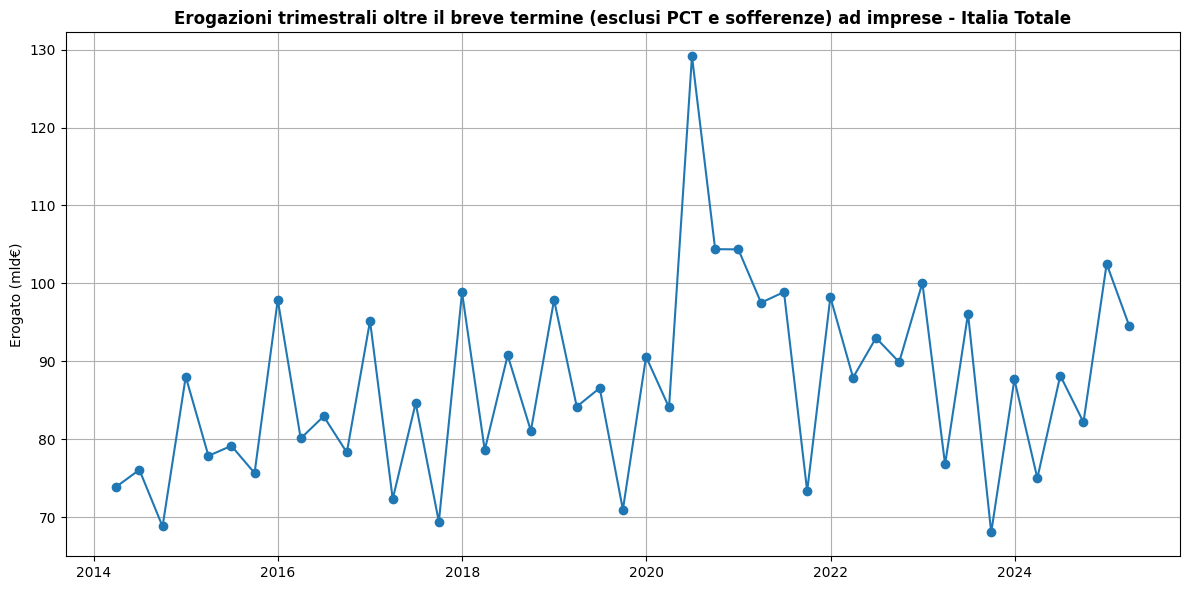

In [72]:
import matplotlib.pyplot as plt

# Crea il lineplot dei valori trimestrali
plt.figure(figsize=(12, 6))
plt.plot(valori_trimestrali['DATA_OSS'], valori_trimestrali['VALORE_MLN'], marker='o')

plt.title('Erogazioni trimestrali oltre il breve termine (esclusi PCT e sofferenze) ad imprese - Italia Totale', fontweight='bold')
#plt.xlabel('Data')
plt.ylabel('Erogato (mld€)')
plt.grid(True)
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [56]:
'''import pandas as pd

# Assumiamo che 'data' sia già caricato e pronto all'uso
# Filtro per condizioni specifiche
filtered_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['LOC_CTP'].astype(str) == 'IT') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()'''

# Conversioni
filtered_df['DATA_OSS'] = pd.to_datetime(filtered_df['DATA_OSS'])
filtered_df['VALORE_MLD'] = filtered_df['VALORE'] / 1e6               # in miliardi

# Aggregazione per anno
filtered_df['ANNO'] = filtered_df['DATA_OSS'].dt.year
valori_annuali = (
    filtered_df.groupby('ANNO')['VALORE_MLD']
    .sum()
    .reset_index()
    .sort_values('ANNO')
)
valori_annuali['VALORE_MLD'].round().astype(int)


0     306826
1     330572
2     336519
3     325186
4     348336
5     332305
6     421996
7     367981
8     370871
9     328579
10    347867
11     94506
Name: VALORE_MLD, dtype: int64

In [59]:
filtered_df[['DATA_OSS','DESINV','LOC_CTP','VALORE','VALORE_MLD']]

DATA_OSS DESINV LOC_CTP       VALORE  VALORE_MLD
414    2025-03-31    912      IT   1375372000    1375.372
579    2025-03-31    902      IT   1331899000    1331.899
1122   2025-03-31    916      IT  81548125000   81548.125
1162   2025-03-31     40      IT     43474000      43.474
2345   2025-03-31    905      IT   7239414000    7239.414
...           ...    ...     ...          ...         ...
201939 2014-03-31    912      IT   1225596000    1225.596
201941 2014-03-31    916      IT  63529328000   63529.328
203574 2014-03-31    905      IT   7244406000    7244.406
204369 2014-03-31    902      IT   1197086000    1197.086
205315 2014-03-31    909      IT    693369000     693.369

[270 rows x 5 columns]

In [52]:
# filtered_df[['DATA_OSS','VALORE_MLD']]
filtered_df[['DATA_OSS', 'VALORE_MLD']].assign(
    VALORE_MLD = filtered_df['VALORE_MLD'].round().astype(int)
)

DATA_OSS  VALORE_MLD
414    2025-03-31           1
579    2025-03-31           1
1122   2025-03-31          82
1162   2025-03-31           0
2345   2025-03-31           7
...           ...         ...
201939 2014-03-31           1
201941 2014-03-31          64
203574 2014-03-31           7
204369 2014-03-31           1
205315 2014-03-31           1

[270 rows x 2 columns]

In [19]:


# Applica il filtro e seleziona le colonne
ItaliaTOT = data[
    (data['TIPTASSO'] == '10000')              # Tasso aggregato
    & (data['LOC_CTP'] == 'IT')                # Italia
    & (data['DESINV'] == '997')                # Tutte le finalità
    & (data['ENTE_SEGN'] == '1070001')         # Fonte
].sort_values(by='DATA_OSS', ascending=True).copy()

# Conversione e scaling del valore
ItaliaTOT['VALORE'] = ItaliaTOT['VALORE'].astype('int64') * 1000
ItaliaTOT['VALORE_MLD'] = ItaliaTOT['VALORE'] / 1e9

# Colonne selezionate finali
ItaliaTOT = ItaliaTOT[['DATA_OSS', 'DESINV', 'LOC_CTP', 'TIPTASSO', 'VALORE', 'VALORE_MLD']]


In [20]:
ItaliaTOT

DATA_OSS DESINV LOC_CTP TIPTASSO        VALORE  VALORE_MLD
203089 2014-03-31    997      IT    10000   80614948000   80.614948
200460 2014-06-30    997      IT    10000   84051210000   84.051210
194786 2014-09-30    997      IT    10000   75800684000   75.800684
187406 2014-12-31    997      IT    10000   95912871000   95.912871
186115 2015-03-31    997      IT    10000   84694591000   84.694591
179015 2015-06-30    997      IT    10000   89505782000   89.505782
174103 2015-09-30    997      IT    10000   87394168000   87.394168
169714 2015-12-31    997      IT    10000  111299898000  111.299898
165339 2016-03-31    997      IT    10000   91301494000   91.301494
162513 2016-06-30    997      IT    10000   97030485000   97.030485
157183 2016-09-30    997      IT    10000   90624086000   90.624086
153563 2016-12-31    997      IT    10000  109801186000  109.801186
149072 2017-03-31    997      IT    10000   84449552000   84.449552
144992 2017-06-30    997      IT    10000   97735869000   97.735869
140362 2017-09-30    997      IT    10000   80756370000   80.756370
135366 2017-12-31    997      IT    10000  111107222000  111.107222
131096 2018-03-31    997      IT    10000   88970226000   88.970226
126365 2018-06-30    997      IT    10000  104279116000  104.279116
122773 2018-09-30    997      IT    10000   92548916000   92.548916
118236 2018-12-31    997      IT    10000  112968185000  112.968185
111776 2019-03-31    997      IT    10000   95079654000   95.079654
108976 2019-06-30    997      IT    10000   98245753000   98.245753
102243 2019-09-30    997      IT    10000   82060166000   82.060166
101537 2019-12-31    997      IT    10000  106511146000  106.511146
96339  2020-03-31    997      IT    10000   95223991000   95.223991
91076  2020-06-30    997      IT    10000  135910204000  135.910204
85961  2020-09-30    997      IT    10000  116467253000  116.467253
79810  2020-12-31    997      IT    10000  120660001000  120.660001
75165  2021-03-31    997      IT    10000  113821144000  113.821144
72075  2021-06-30    997      IT    10000  116124484000  116.124484
66434  2021-09-30    997      IT    10000   88702752000   88.702752
63374  2021-12-31    997      IT    10000  115363120000  115.363120
57201  2022-03-31    997      IT    10000  102830233000  102.830233
53632  2022-06-30    997      IT    10000  110185351000  110.185351
49241  2022-09-30    997      IT    10000  104161715000  104.161715
45533  2022-12-31    997      IT    10000  113587845000  113.587845
36995  2023-03-31    997      IT    10000   88038190000   88.038190
33545  2023-06-30    997      IT    10000  105632590000  105.632590
30606  2023-09-30    997      IT    10000   78691846000   78.691846
26166  2023-12-31    997      IT    10000  100052101000  100.052101
19778  2024-03-31    997      IT    10000   84379036000   84.379036
17139  2024-06-30    997      IT    10000  100574607000  100.574607
10992  2024-09-30    997      IT    10000   94207003000   94.207003
6163   2024-12-31    997      IT    10000  118607031000  118.607031
2305   2025-03-31    997      IT    10000  108630031000  108.630031

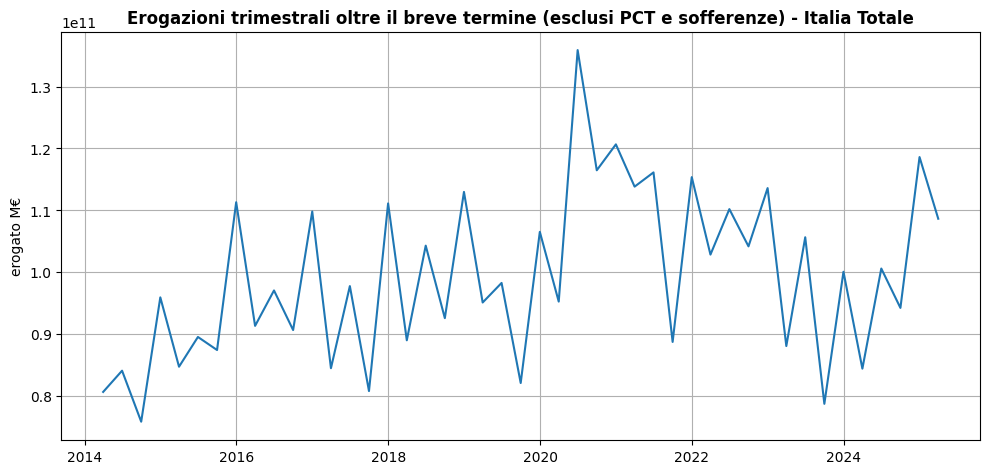

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(ItaliaTOT['DATA_OSS'], ItaliaTOT['VALORE'], ) # marker='o'
plt.title('Erogazioni trimestrali oltre il breve termine (esclusi PCT e sofferenze) - Italia Totale', weight='bold')
# plt.xlabel('Data')

plt.ylabel('erogato M€')
plt.grid(True)
plt.tight_layout()
plt.show()


## facet delle 8 regioni del mezzogiorno

In [23]:
# Estrai il trimestre più recente
ultimo_periodo = data['DATA_OSS'].max()

# Definisci le due macroaree
regioni_mezzogiorno = [
    'ITF1', 'ITF2', 'ITF3', 'ITF4', 'ITF5', 'ITF6', 'ITG1', 'ITG2'
]

# Aggiungi AREA al dataset
data['LOC_CTP'] = data['LOC_CTP'].astype(str)
data['AREA'] = data['LOC_CTP'].apply(lambda x: 'Mezzogiorno' if x in regioni_mezzogiorno else 'CentroNord')

# Filtra per trimestre più recente e condizioni valide
filtered_latest = data[
    (data['DATA_OSS'] == ultimo_periodo) &
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversione VALORE in miliardi
filtered_latest['VALORE'] = filtered_latest['VALORE'].astype('int64') * 1000
filtered_latest['VALORE_MLD'] = filtered_latest['VALORE'] / 1e9

# Somma per AREA
somme_per_area = filtered_latest.groupby('AREA')['VALORE_MLD'].sum().reset_index()

somme_per_area


AREA  VALORE_MLD
0   CentroNord  418.496759
1  Mezzogiorno   16.023360

In [24]:
# Verifica che ItaliaTOT contenga dati regionali
regionali_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversioni
regionali_df['VALORE'] = regionali_df['VALORE'].astype('int64') * 1000
regionali_df['VALORE_MLD'] = regionali_df['VALORE'] / 1e9
regionali_df['DATA_OSS'] = pd.to_datetime(regionali_df['DATA_OSS'])

# Trova l'ultimo trimestre disponibile
ultimo_periodo = regionali_df['DATA_OSS'].max()

# Filtra per l'ultimo trimestre
ultime_regioni = regionali_df[regionali_df['DATA_OSS'] == ultimo_periodo].copy()

# Mappa dei codici regione ai nomi
regioni_nomi = {
    'ITC1': 'Piemonte',
    'ITC2': 'Valle d’Aosta',
    'ITC3': 'Liguria',
    'ITC4': 'Lombardia',
    'ITF1': 'Abruzzo',
    'ITF2': 'Molise',
    'ITF3': 'Campania',
    'ITF4': 'Puglia',
    'ITF5': 'Basilicata',
    'ITF6': 'Calabria',
    'ITG1': 'Sicilia',
    'ITG2': 'Sardegna',
    'ITH10': 'Bolzano',
    'ITH20': 'Trento',
    'ITH3': 'Veneto',
    'ITH4': 'Friuli-Venezia Giulia',
    'ITH5': 'Emilia-Romagna',
    'ITI1': 'Toscana',
    'ITI2': 'Umbria',
    'ITI3': 'Marche',
    'ITI4': 'Lazio',
}

ultime_regioni['REGIONE'] = ultime_regioni['LOC_CTP'].map(regioni_nomi)

# Raggruppa per regione
erogazioni_finali = ultime_regioni.groupby(['REGIONE'])['VALORE_MLD'].sum().reset_index().sort_values('VALORE_MLD', ascending=False)
erogazioni_finali


REGIONE  VALORE_MLD
9               Lombardia   34.580084
7                   Lazio   13.857938
5          Emilia-Romagna   10.655783
20                 Veneto    8.845443
12               Piemonte    7.466766
16                Toscana    6.552510
4                Campania    4.680936
15                Sicilia    3.834659
13                 Puglia    3.372981
6   Friuli-Venezia Giulia    2.356341
10                 Marche    2.294019
8                 Liguria    1.929861
2                 Bolzano    1.580975
0                 Abruzzo    1.324889
14               Sardegna    1.189155
18                 Umbria    1.097667
3                Calabria    1.032883
17                 Trento    0.887903
19          Valle d’Aosta    0.501381
1              Basilicata    0.373017
11                 Molise    0.214840

In [25]:
erogazioni_finali['VALORE_MLD'].sum()

np.float64(108.63003099999997)

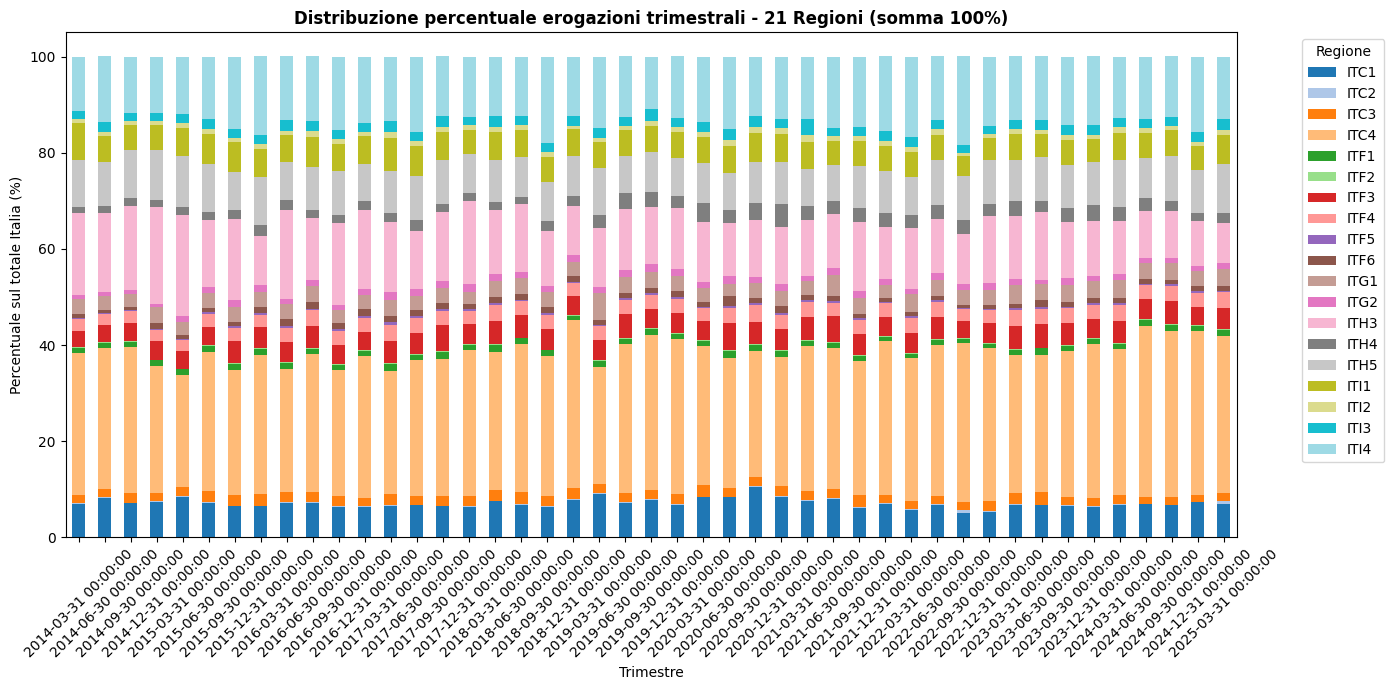

In [26]:
regioni_codici = [
    'ITC1', 'ITC2', 'ITC3', 'ITC4',     # Piemonte, Valle d’Aosta, Liguria, Lombardia
    'ITF1', 'ITF2', 'ITF3', 'ITF4',     # Abruzzo, Molise, Campania, Puglia
    'ITF5', 'ITF6',                     # Basilicata, Calabria
    'ITG1', 'ITG2',                     # Sicilia, Sardegna
    'ITH1', 'ITH2', 'ITH3', 'ITH4', 'ITH5',  # Bolzano, Trento, Veneto, FVG, Emilia-Romagna
    'ITI1', 'ITI2', 'ITI3', 'ITI4'      # Toscana, Umbria, Marche, Lazio
]


import pandas as pd
import matplotlib.pyplot as plt

# Filtro solo per le 21 regioni italiane
regioni_codici = [
    'ITC1', 'ITC2', 'ITC3', 'ITC4',
    'ITF1', 'ITF2', 'ITF3', 'ITF4', 'ITF5', 'ITF6',
    'ITG1', 'ITG2',
    'ITH1', 'ITH2', 'ITH3', 'ITH4', 'ITH5',
    'ITI1', 'ITI2', 'ITI3', 'ITI4'
]

regioni_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_codici))
].copy()

# Conversioni
regioni_df['VALORE'] = regioni_df['VALORE'].astype('int64') * 1000
regioni_df['VALORE_MLD'] = regioni_df['VALORE'] / 1e9
regioni_df['DATA_OSS'] = pd.to_datetime(regioni_df['DATA_OSS'])

# Matrice regioni × trimestre
pivot_df = regioni_df.pivot_table(
    index='DATA_OSS',
    columns='LOC_CTP',
    values='VALORE_MLD',
    aggfunc='sum'
)

# Percentuali su base 100 per ogni trimestre
percentuali_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
percentuali_df = percentuali_df.round(2)

# Plot stacked barplot
percentuali_df.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    colormap='tab20'
)

plt.title('Distribuzione percentuale erogazioni trimestrali - 21 Regioni (somma 100%)', fontweight='bold')
plt.xlabel('Trimestre')
plt.ylabel('Percentuale sul totale Italia (%)')
plt.xticks(rotation=45)
plt.legend(title='Regione', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




In [27]:
import pandas as pd

# Filtro per le 21 regioni italiane
regioni_codici = [
    'ITC1','ITC2','ITC3','ITC4',
    'ITF1','ITF2','ITF3','ITF4','ITF5','ITF6',
    'ITG1','ITG2',
    'ITH1','ITH2','ITH3','ITH4','ITH5',
    'ITI1','ITI2','ITI3','ITI4'
]

df_reg = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_codici))
].copy()

# Prepara i dati
df_reg['DATA_OSS'] = pd.to_datetime(df_reg['DATA_OSS'])
df_reg['VALORE_MLD'] = df_reg['VALORE'] / 1e6

# Costruisci il pivot con valori assoluti
pivot_assoluti = df_reg.pivot_table(
    index='DATA_OSS',
    columns='LOC_CTP',
    values='VALORE_MLD',
    aggfunc='sum'
).fillna(0).sort_index()

pivot_assoluti.tail().T


DATA_OSS  2024-03-31  2024-06-30  2024-09-30  2024-12-31  2025-03-31
LOC_CTP                                                             
ITC1        5.576034    6.727404    6.127229    8.487049    7.466766
ITC2        0.145515    0.126843    0.115476     0.13032    0.501381
ITC3        1.441007    1.295181    1.386555    1.565072    1.929861
ITC4       24.960386   34.964244   31.774956   39.490414   34.580084
ITF1        0.972593    1.121122    1.069142    1.172137    1.324889
ITF2        0.149368    0.161161    0.148296    0.189655     0.21484
ITF3        3.753021    4.152555    4.389066    4.387226    4.680936
ITF4        2.788277    2.790404    2.916459    3.498974    3.372981
ITF5        0.268107    0.340857    0.307915    0.368375    0.373017
ITF6        0.798459    0.833961    0.842669    1.240154    1.032883
ITG1        3.207233     3.28391    3.118283    3.652259    3.834659
ITG2        0.892243    1.127396    1.094931    1.158467    1.189155
ITH3        9.077194    9.514683     8.80819   10.769253    8.845443
ITH4        2.373043     2.59818    2.054156    2.041679    2.356341
ITH5        8.098717    8.278157    8.557395    10.35775   10.655783
ITI1        4.590982    5.071481    4.840044    5.790479     6.55251
ITI2        0.950982    0.874112     0.80277    1.000088    1.097667
ITI3        1.634834    1.835156    1.764396    2.231412    2.294019
ITI4       10.475099    12.78463   11.503581   18.281892   13.857938

In [121]:
import matplotlib.pyplot as plt

# Lista codici regioni del Mezzogiorno (codici LOC_CTP regionali)
regioni_mezzogiorno = [
    'ITF1',  # Abruzzo
    'ITF2',  # Molise
    'ITF3',  # Campania
    'ITF4',  # Puglia
    'ITF5',  # Basilicata
    'ITF6',  # Calabria
    'ITG1',  # Sicilia
    'ITG2',  # Sardegna
]

# Filtra il DataFrame per le regioni del Mezzogiorno
mezzogiorno_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_mezzogiorno))
].copy()

# Conversioni
mezzogiorno_df['VALORE'] = mezzogiorno_df['VALORE'].astype('int64') * 1000
mezzogiorno_df['VALORE_MLD'] = mezzogiorno_df['VALORE'] / 1e9
mezzogiorno_df['DATA_OSS'] = pd.to_datetime(mezzogiorno_df['DATA_OSS'])

# Mappa dei codici ai nomi delle regioni
regioni_nomi = {
    'ITF1': 'Abruzzo',
    'ITF2': 'Molise',
    'ITF3': 'Campania',
    'ITF4': 'Puglia',
    'ITF5': 'Basilicata',
    'ITF6': 'Calabria',
    'ITG1': 'Sicilia',
    'ITG2': 'Sardegna',
}
mezzogiorno_df['REGIONE'] = mezzogiorno_df['LOC_CTP'].map(regioni_nomi)

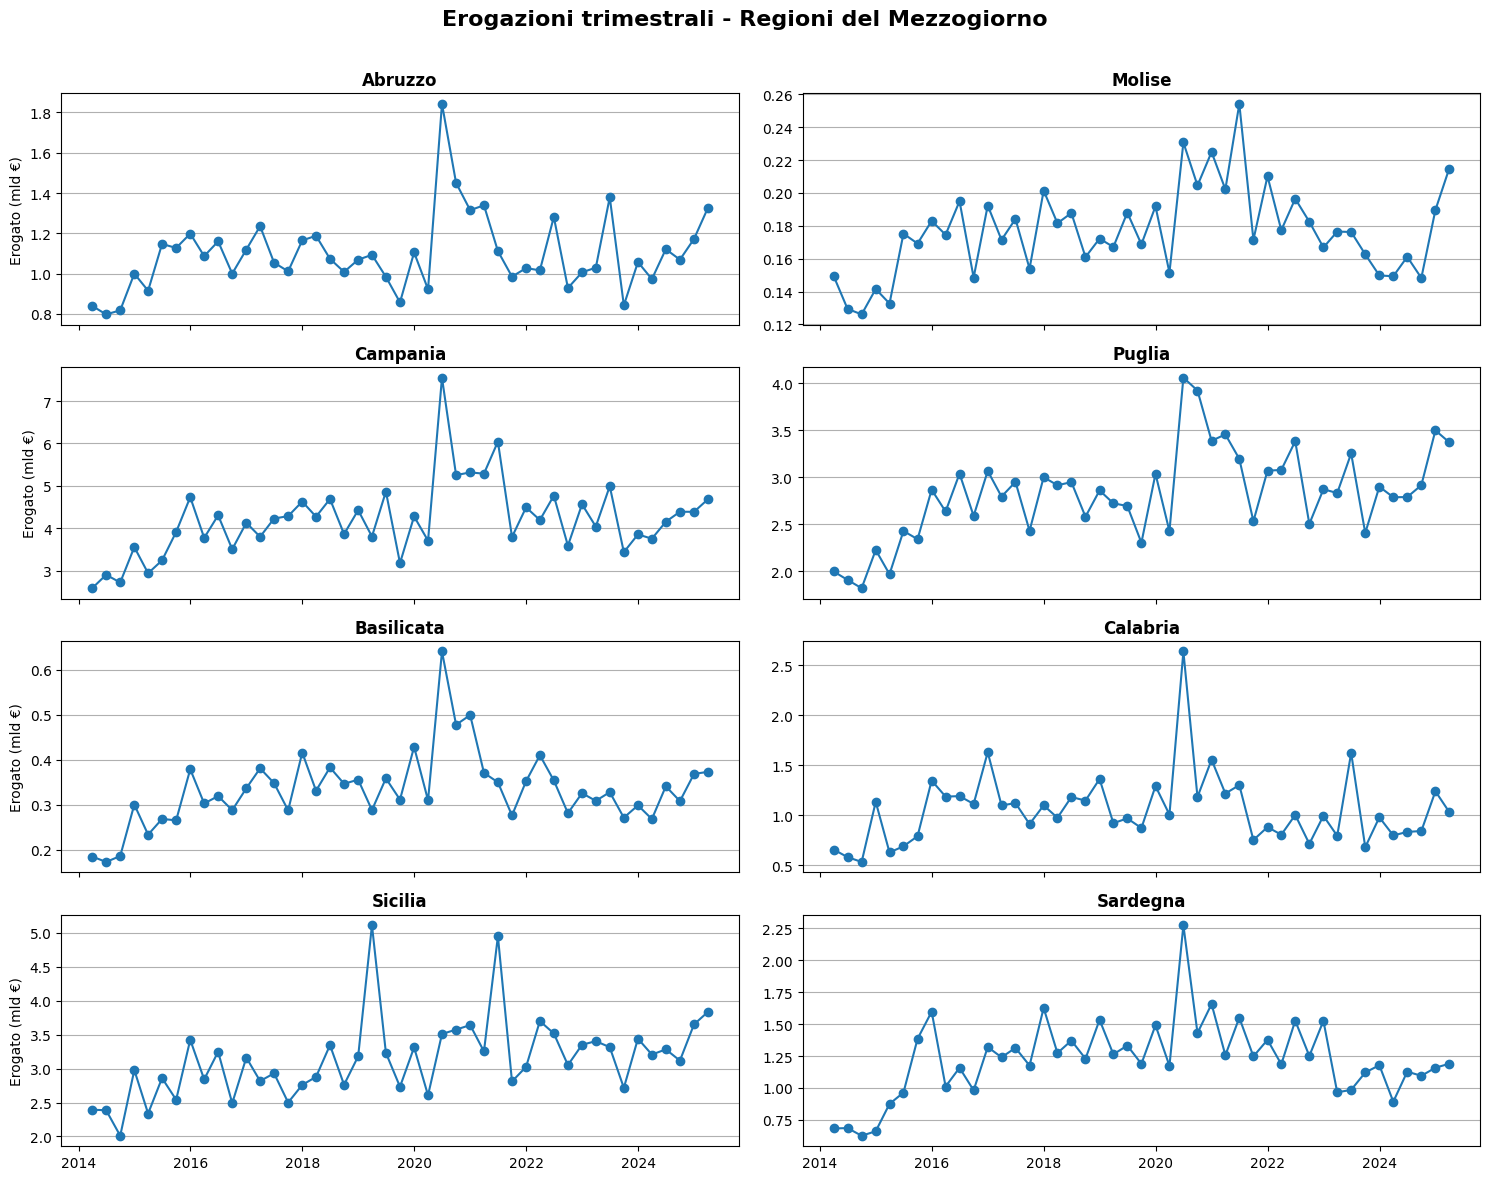

In [ ]:
# Plot a facet (8 subplot, uno per regione) - LINEPLOT VERSION
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()

for i, regione in enumerate(regioni_nomi.values()):
    subset = mezzogiorno_df[mezzogiorno_df['REGIONE'] == regione]
    axes[i].plot(subset['DATA_OSS'], subset['VALORE_MLD'], marker='o')
    axes[i].set_title(regione, fontweight='bold')
    axes[i].tick_params(axis='x')
    axes[i].grid(True, axis='y')
    if i % 2 == 0:
        axes[i].set_ylabel('Erogato (mld €)')

fig.suptitle('Erogazioni trimestrali - Regioni del Mezzogiorno', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [128]:
print(data['DESINV'].dropna().unique())



['909' '916' '998' '997' '10' '120' '902' '110' '40' '905' '912' '914'
 '80' '70']


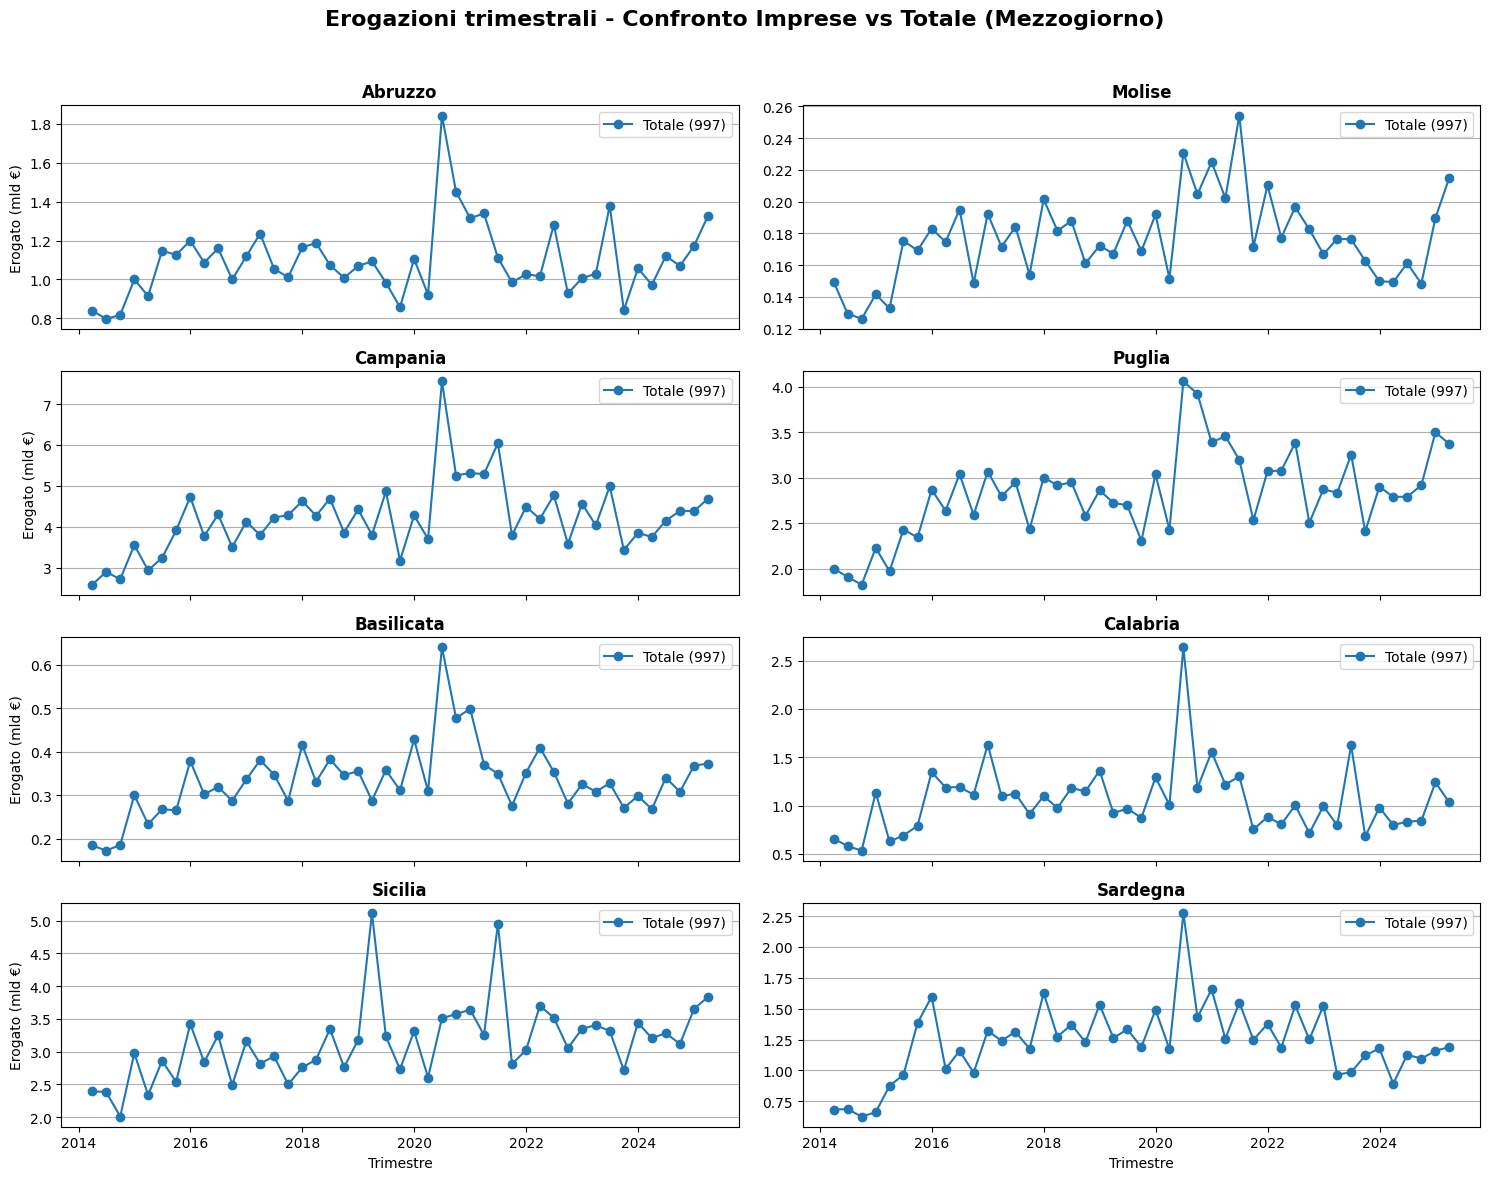

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Codici delle regioni del Mezzogiorno
regioni_mezzogiorno = [
    'ITF1',  # Abruzzo
    'ITF2',  # Molise
    'ITF3',  # Campania
    'ITF4',  # Puglia
    'ITF5',  # Basilicata
    'ITF6',  # Calabria
    'ITG1',  # Sicilia
    'ITG2',  # Sardegna
]

# Mappatura nomi regioni
regioni_nomi = {
    'ITF1': 'Abruzzo',
    'ITF2': 'Molise',
    'ITF3': 'Campania',
    'ITF4': 'Puglia',
    'ITF5': 'Basilicata',
    'ITF6': 'Calabria',
    'ITG1': 'Sicilia',
    'ITG2': 'Sardegna',
}

# --- Somma finalità imprese (DESINV 101-105) ---
desinv_imprese = ['101', '102', '103', '104', '105']
df_imprese = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str).isin(desinv_imprese)) &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_mezzogiorno))
].copy()

df_imprese['VALORE'] = df_imprese['VALORE'].astype('int64') * 1000
df_imprese['VALORE_MLD'] = df_imprese['VALORE'] / 1e9
df_imprese['DATA_OSS'] = pd.to_datetime(df_imprese['DATA_OSS'])
df_imprese['REGIONE'] = df_imprese['LOC_CTP'].map(regioni_nomi)

# Aggrega per trimestre e regione
imprese_aggregati = df_imprese.groupby(['DATA_OSS', 'REGIONE'])['VALORE_MLD'].sum().reset_index()
imprese_aggregati['TIPO'] = 'Imprese (101-105)'

# --- Valore ufficiale totale (DESINV 997) ---
df_997 = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_mezzogiorno))
].copy()

df_997['VALORE'] = df_997['VALORE'].astype('int64') * 1000
df_997['VALORE_MLD'] = df_997['VALORE'] / 1e9
df_997['DATA_OSS'] = pd.to_datetime(df_997['DATA_OSS'])
df_997['REGIONE'] = df_997['LOC_CTP'].map(regioni_nomi)
df_997['TIPO'] = 'Totale (997)'

# --- Unione per confronto ---
df_plot = pd.concat([
    imprese_aggregati[['DATA_OSS', 'REGIONE', 'VALORE_MLD', 'TIPO']],
    df_997[['DATA_OSS', 'REGIONE', 'VALORE_MLD', 'TIPO']]
])

# --- Facet plot 8 regioni ---
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()

for i, regione in enumerate(regioni_nomi.values()):
    ax = axes[i]
    subset = df_plot[df_plot['REGIONE'] == regione]
    for tipo in subset['TIPO'].unique():
        data_tipo = subset[subset['TIPO'] == tipo]
        ax.plot(data_tipo['DATA_OSS'], data_tipo['VALORE_MLD'], label=tipo, marker='o')
    ax.set_title(regione, fontweight='bold')
    ax.grid(True, axis='y')
    if i % 2 == 0:
        ax.set_ylabel('Erogato (mld €)')
    if i >= 6:
        ax.set_xlabel('Trimestre')
    ax.legend()

fig.suptitle('Erogazioni trimestrali - Confronto Imprese vs Totale (Mezzogiorno)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




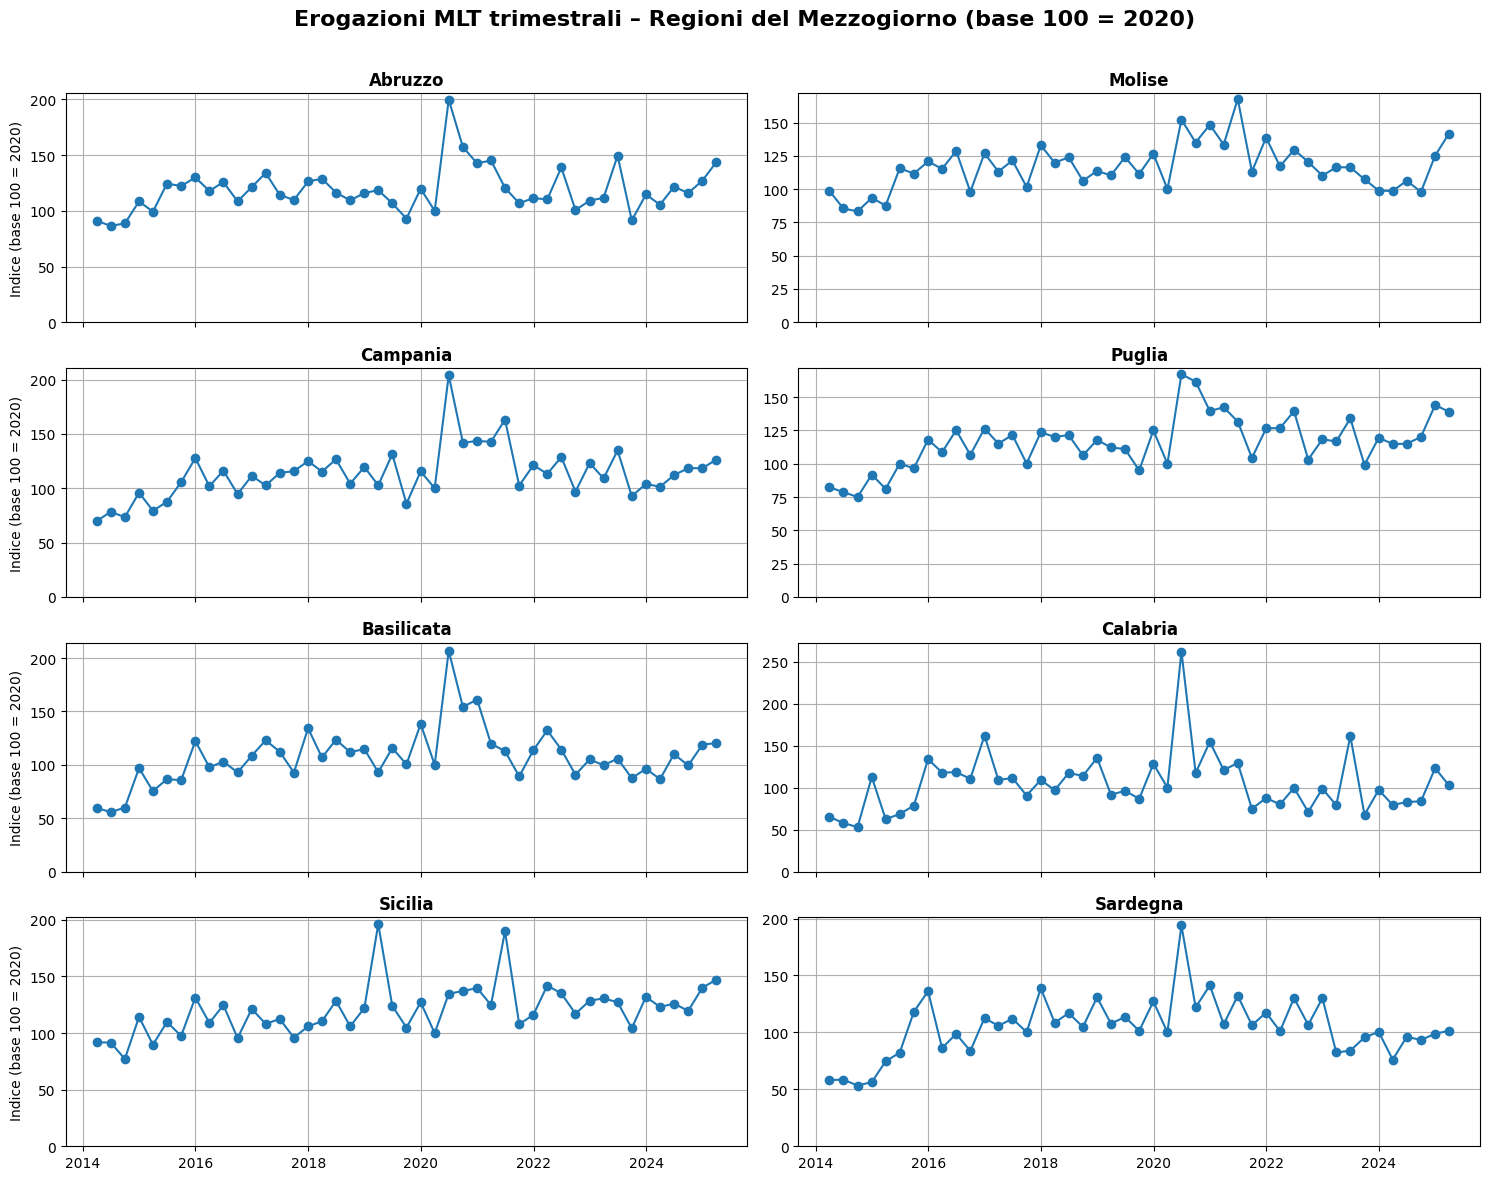

In [29]:
import matplotlib.pyplot as plt

# Assicura conversioni corrette
mezzogiorno_df['DATA_OSS'] = pd.to_datetime(mezzogiorno_df['DATA_OSS'])
mezzogiorno_df['VALORE'] = mezzogiorno_df['VALORE'].astype('int64') * 1000
mezzogiorno_df['VALORE_MLD'] = mezzogiorno_df['VALORE'] / 1e9

# Mappa codice → nome
mezzogiorno_df['REGIONE'] = mezzogiorno_df['LOC_CTP'].map(regioni_nomi)

# Calcolo base 100 sul primo trimestre 2020
df_base100 = mezzogiorno_df.copy()

base_2020 = df_base100[df_base100['DATA_OSS'] >= '2020-01-01'] \
    .sort_values('DATA_OSS') \
    .groupby('REGIONE').first()  # primo trimestre 2020 disponibile per ogni regione

# Normalizza
def normalizza_base100(row):
    base = base_2020.loc[row['REGIONE']]['VALORE_MLD']
    return (row['VALORE_MLD'] / base) * 100 if base > 0 else None

df_base100['INDICE_2020'] = df_base100.apply(normalizza_base100, axis=1)

# Facet plot (8 regioni)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()

for i, regione in enumerate(regioni_nomi.values()):
    subset = df_base100[df_base100['REGIONE'] == regione]
    axes[i].plot(subset['DATA_OSS'], subset['INDICE_2020'], marker='o')
    axes[i].set_title(regione, fontweight='bold')
    axes[i].grid(True)
    if i % 2 == 0:
        axes[i].set_ylabel('Indice (base 100 = 2020)')
    axes[i].set_ylim(bottom=0)

fig.suptitle('Erogazioni MLT trimestrali – Regioni del Mezzogiorno (base 100 = 2020)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


I **due grafici facet**  mostrano le erogazioni MLT trimestrali per le regioni del **Mezzogiorno**, rispettivamente:

1. 📈 **Grafico 1 – Indice base 100 (2020)**
2. 📊 **Grafico 2 – Valori assoluti (mld €)**



## **Lettura combinata**

| Regione        | Tendenza base 100                                    | Erogato assoluto (range) | Osservazioni                                     |
| -------------- | ---------------------------------------------------- | ------------------------ | ------------------------------------------------ |
| **Abruzzo**    | Forte picco nel 2020, poi discesa e risalita recente | \~1.0–1.8 mld            | Andamento instabile post-COVID                   |
| **Molise**     | Stabile con lieve calo nel 2022–2024                 | \~0.15–0.25 mld          | Fluttuazioni modeste                             |
| **Campania**   | Moderata crescita costante                           | \~3.5–7.0 mld            | Regione con valori più elevati e buon dinamismo  |
| **Puglia**     | Crescita progressiva e regolare                      | \~2.0–3.7 mld            | Solida traiettoria di crescita nel lungo periodo |
| **Basilicata** | Picco nel 2020 poi stabilizzazione                   | \~0.3–0.6 mld            | Picco anomalo, ma tendenziale stabilità          |
| **Calabria**   | Alta variabilità e picchi isolati                    | \~0.8–2.5 mld            | Forte discontinuità, forse per progetti spot     |
| **Sicilia**    | Trend crescente post-2021                            | \~2.5–5.0 mld            | Rimbalzo deciso nel 2024                         |
| **Sardegna**   | Tendenza stabile, lieve calo                         | \~1.0–2.0 mld            | Limitato dinamismo nel post-pandemia             |


* L’indice **base 100** evidenzia bene la **dinamica percentuale**: regioni come **Puglia, Campania e Sicilia** mostrano progressioni robuste nel tempo.
* I **valori assoluti** mostrano che **Campania e Sicilia** sono le regioni con il maggiore peso creditizio nel Mezzogiorno.
* Alcune regioni (es. **Calabria, Basilicata, Abruzzo**) mostrano **forte volatilità**, probabilmente legata a interventi puntuali o progetti specifici.



> L’analisi delle erogazioni MLT nel Mezzogiorno, espressa sia in termini assoluti che relativi (base 100 = 2020), conferma una **forte eterogeneità territoriale**. Le regioni più popolose, come **Campania e Sicilia**, registrano i volumi maggiori e mostrano una buona dinamica di crescita nel medio termine. La **Puglia** spicca per la continuità dell’espansione, mentre **Basilicata e Calabria** si distinguono per l’elevata volatilità. Nel complesso, il biennio 2020–2021 segna un punto di discontinuità, seguito da una **ripresa graduale** nel 2024, potenzialmente connessa all’attivazione delle misure del **PNRR e della ZES unica**.

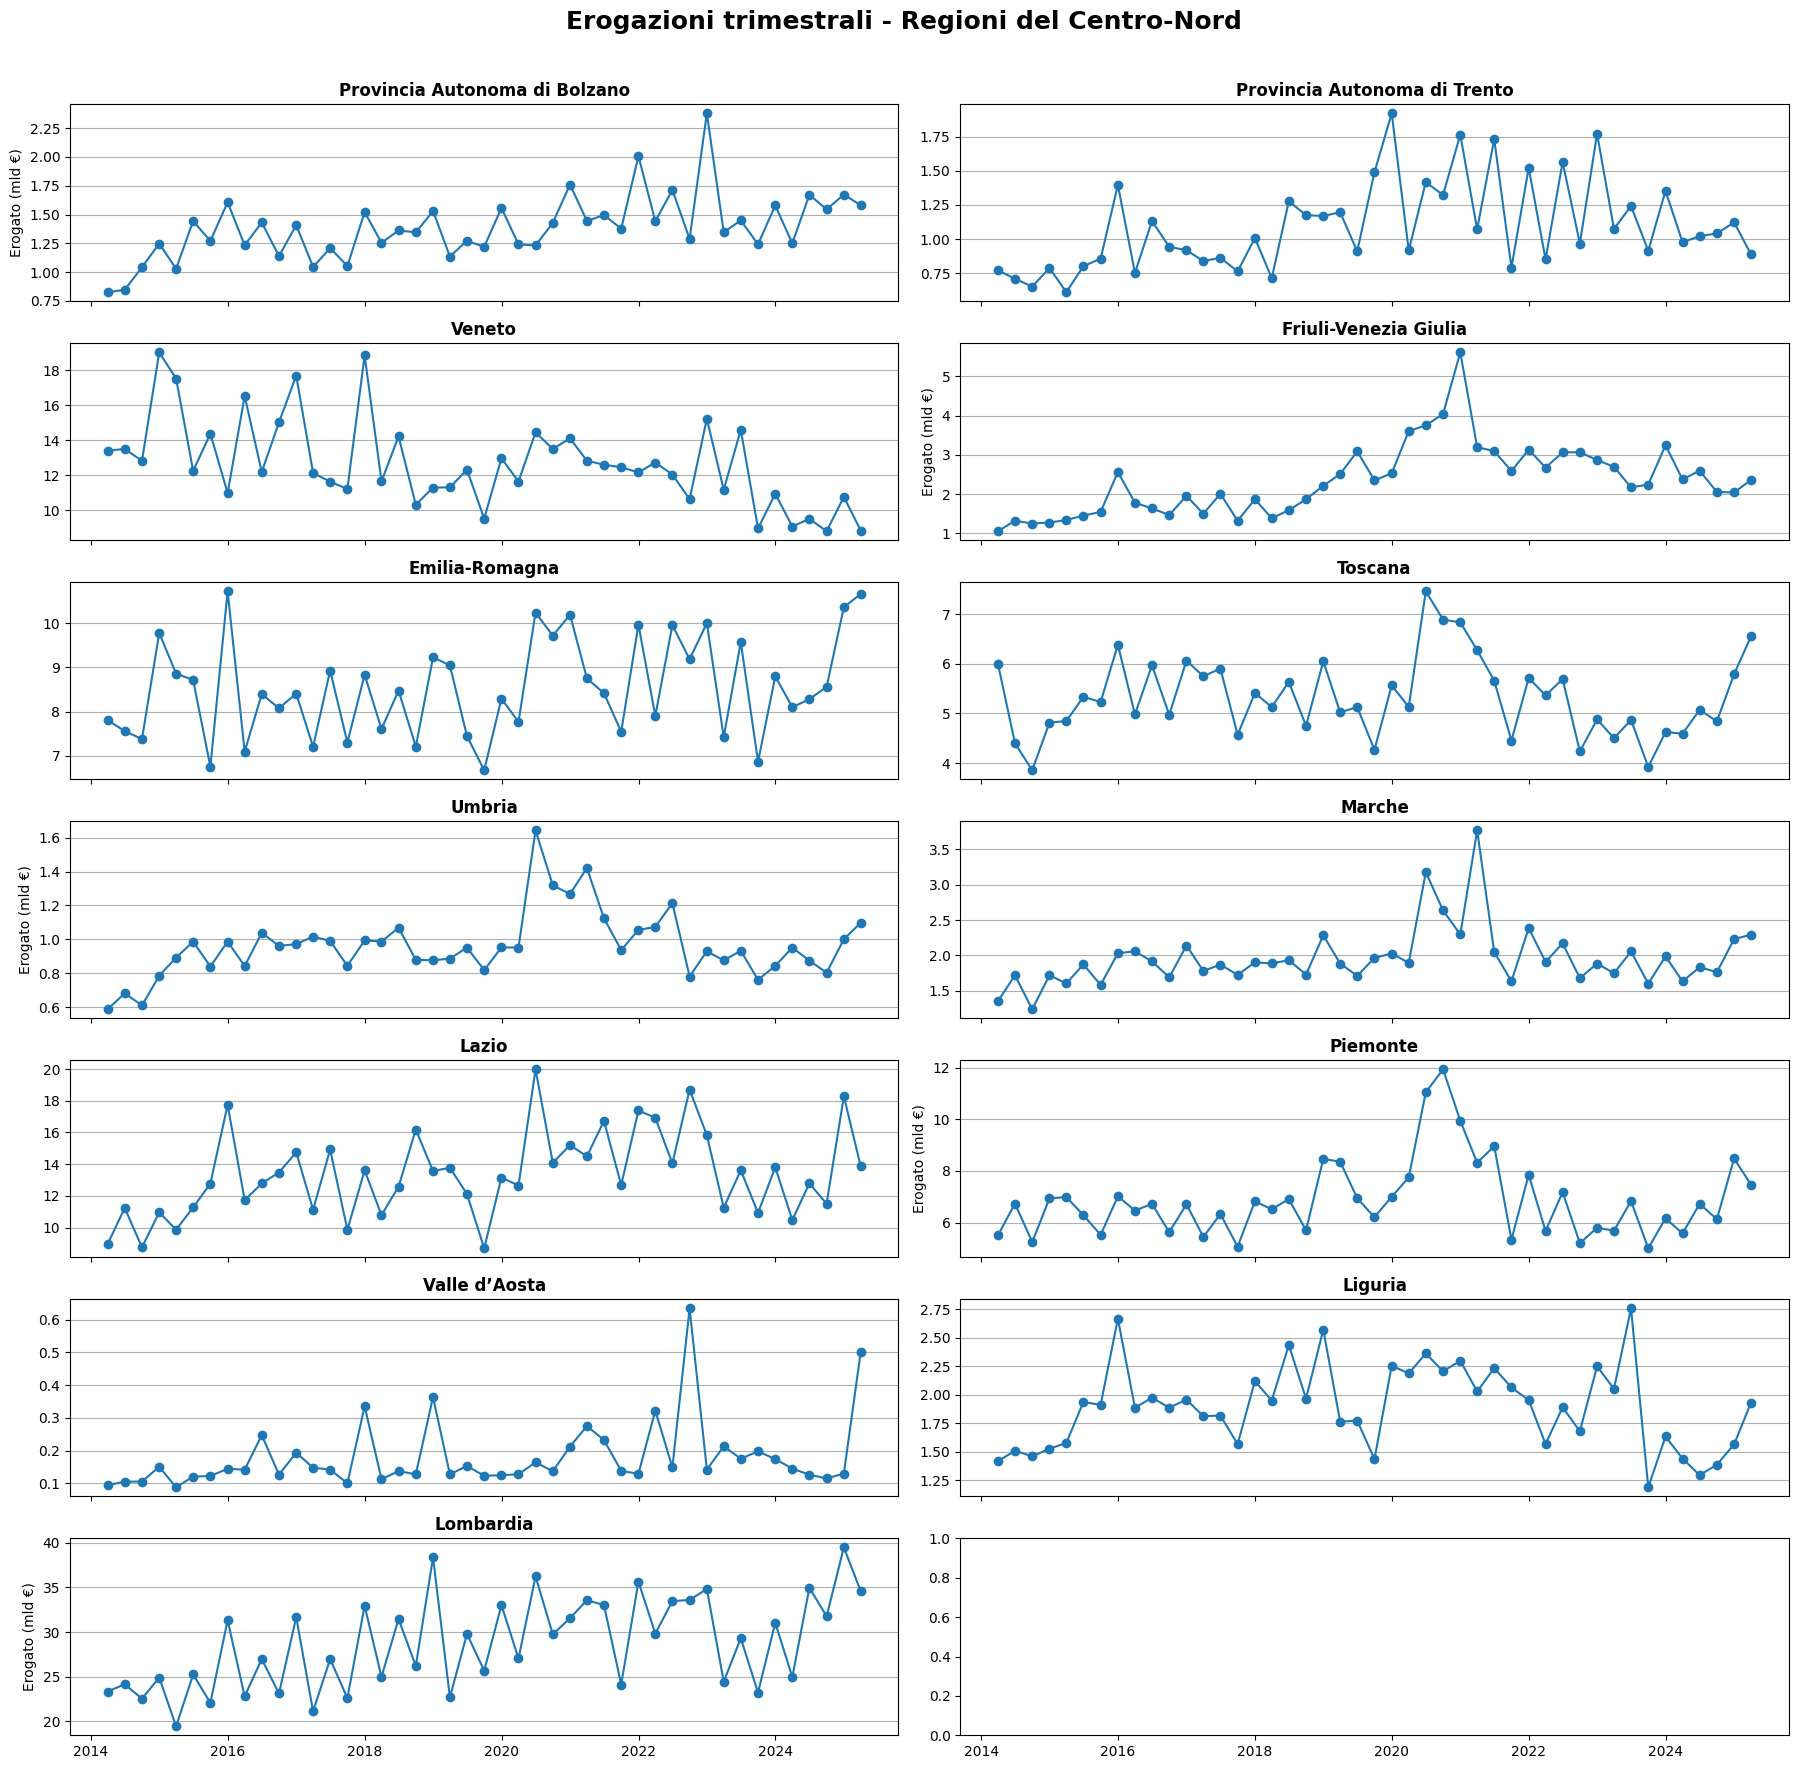

In [30]:
import matplotlib.pyplot as plt

# Codici LOC_CTP delle 18 regioni del Centro-Nord
regioni_centronord = {
    'ITH10': 'Provincia Autonoma di Bolzano',
    'ITH20': 'Provincia Autonoma di Trento',
    'ITH3': 'Veneto',
    'ITH4': 'Friuli-Venezia Giulia',
    'ITH5': 'Emilia-Romagna',
    'ITI1': 'Toscana',
    'ITI2': 'Umbria',
    'ITI3': 'Marche',
    'ITI4': 'Lazio',
    'ITC1': 'Piemonte',
    'ITC2': 'Valle d’Aosta',
    'ITC3': 'Liguria',
    'ITC4': 'Lombardia',
}

# Filtro DataFrame
centronord_df = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['DESINV'].astype(str) == '997') &
    (data['ENTE_SEGN'].astype(str) == '1070001') &
    (data['LOC_CTP'].isin(regioni_centronord.keys()))
].copy()

# Conversioni
centronord_df['VALORE'] = centronord_df['VALORE'].astype('int64') * 1000
centronord_df['VALORE_MLD'] = centronord_df['VALORE'] / 1e9
centronord_df['DATA_OSS'] = pd.to_datetime(centronord_df['DATA_OSS'])
centronord_df['REGIONE'] = centronord_df['LOC_CTP'].map(regioni_centronord)

# Plot a facet (13 subplot, uno per regione)
fig, axes = plt.subplots(7, 2, figsize=(18, 18), sharex=True)

axes = axes.flatten()

for i, regione in enumerate(regioni_centronord.values()):
    subset = centronord_df[centronord_df['REGIONE'] == regione]
    axes[i].plot(subset['DATA_OSS'], subset['VALORE_MLD'], marker='o')
    axes[i].set_title(regione, fontweight='bold')
    # axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y')
    if i % 3 == 0:
        axes[i].set_ylabel('Erogato (mld €)')

fig.suptitle('Erogazioni trimestrali - Regioni del Centro-Nord', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


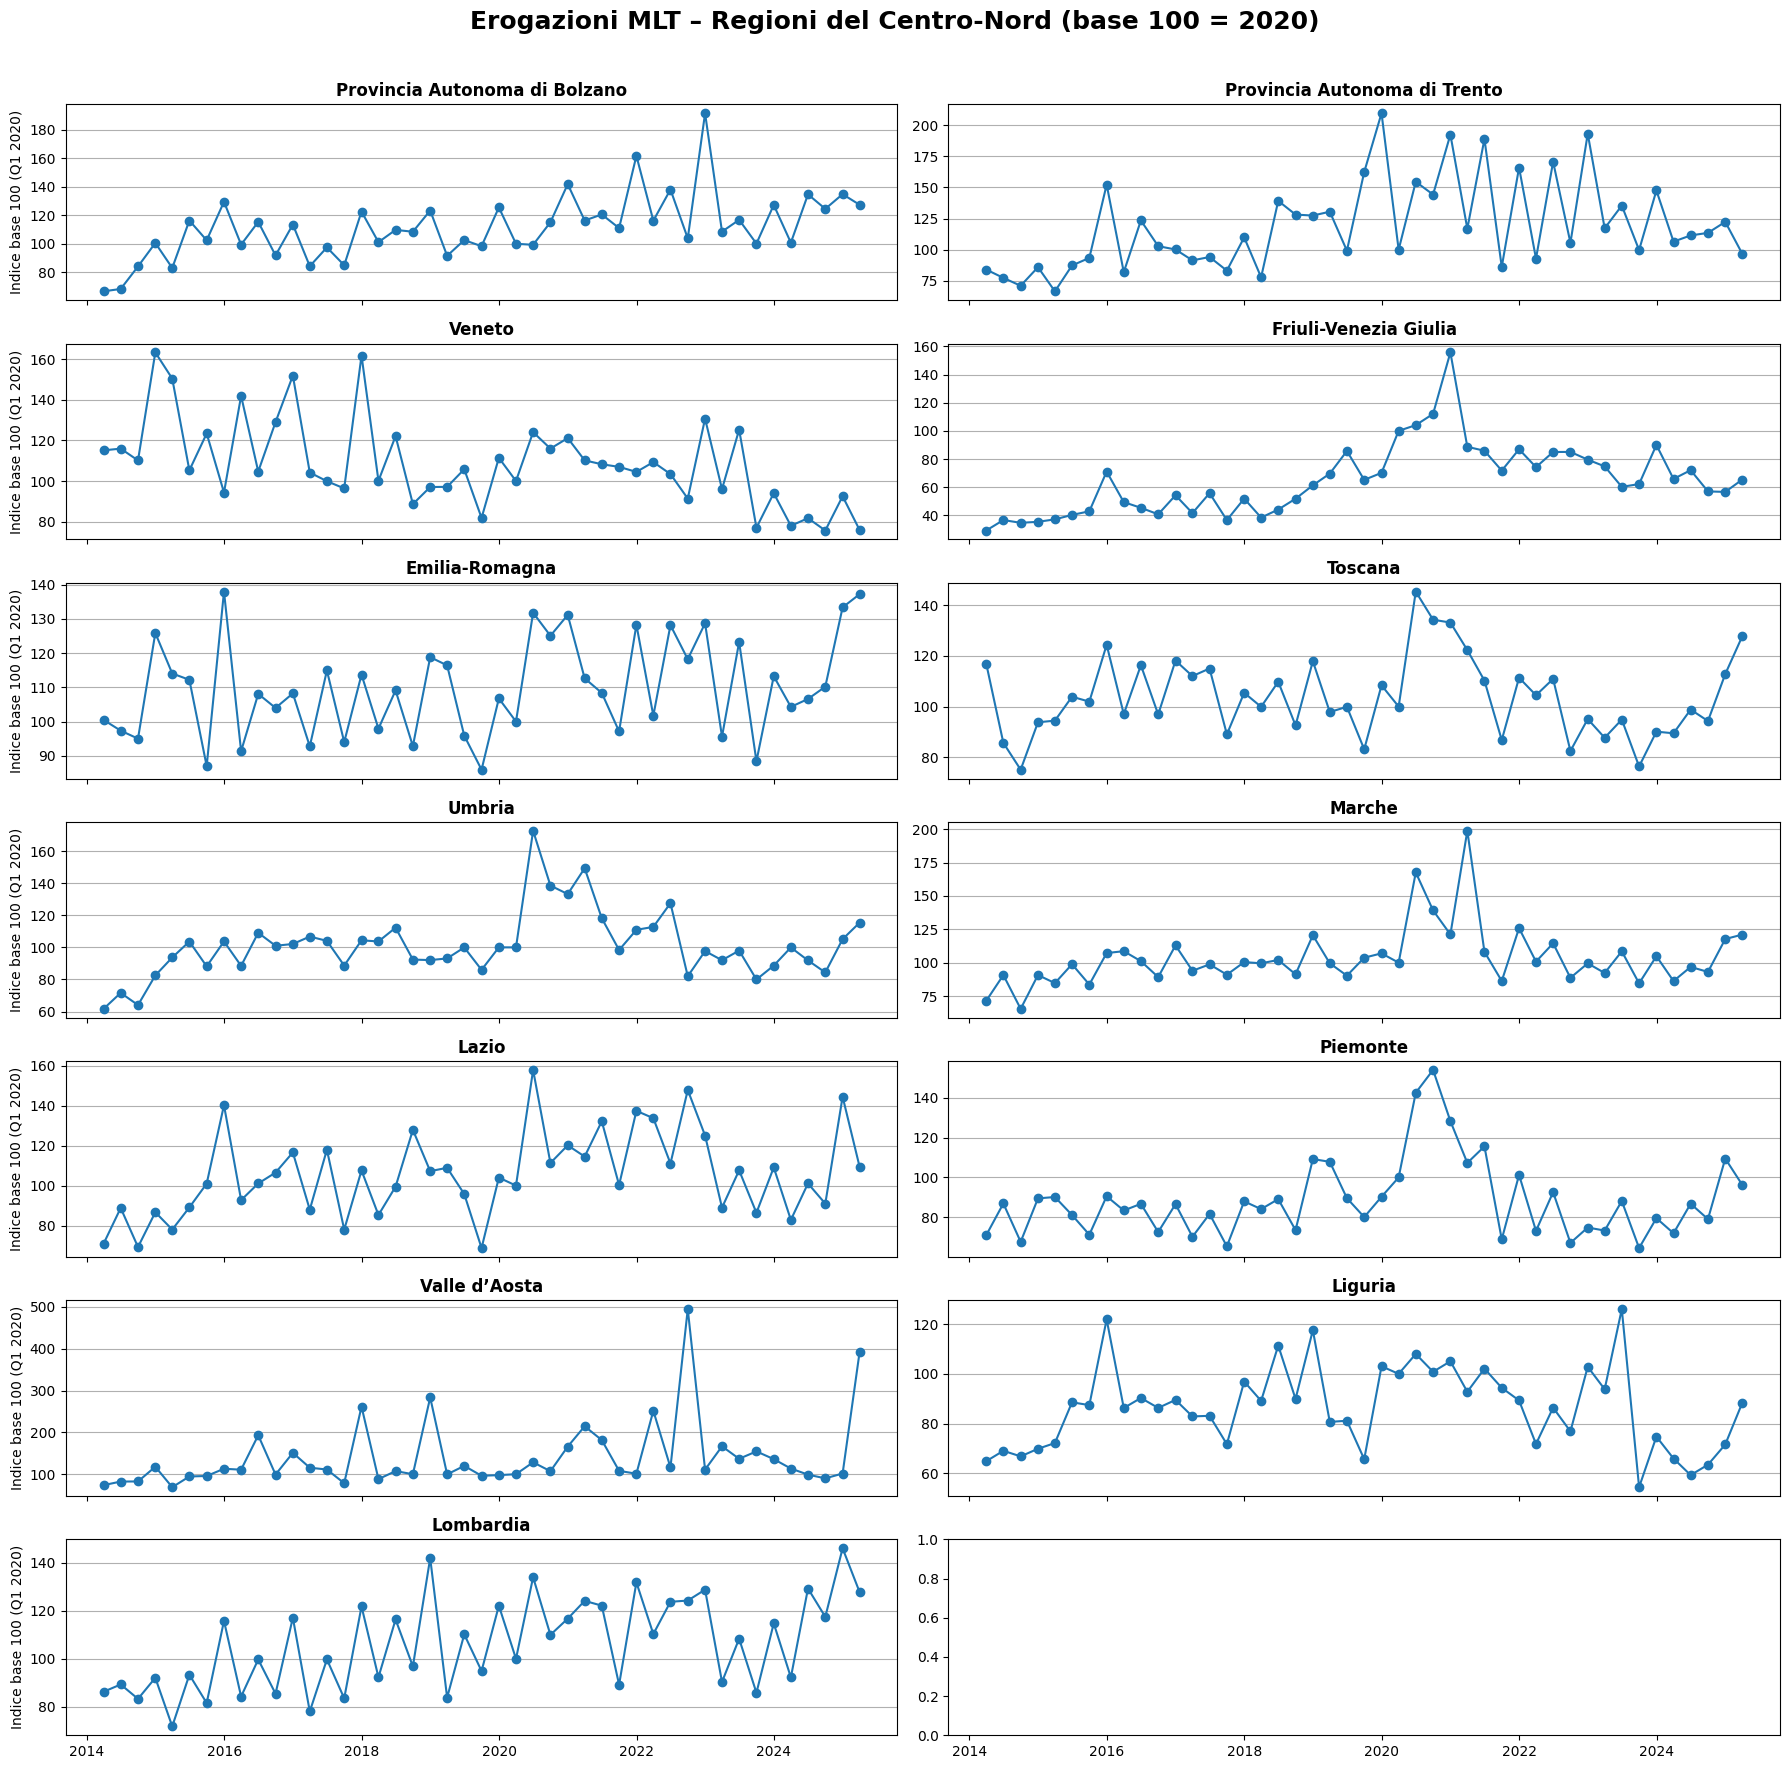

In [31]:
# Calcolo base 100 rispetto al primo trimestre del 2020
df_base100 = centronord_df.copy()

base_2020 = df_base100[df_base100['DATA_OSS'] >= '2020-01-01'] \
    .sort_values('DATA_OSS') \
    .groupby('REGIONE').first()  # primo valore 2020 per ogni regione

def normalizza_base100(row):
    base = base_2020.loc[row['REGIONE']]['VALORE_MLD']
    return (row['VALORE_MLD'] / base) * 100 if base > 0 else None

df_base100['INDICE_2020'] = df_base100.apply(normalizza_base100, axis=1)

# Plot in base 100
fig, axes = plt.subplots(7, 2, figsize=(18, 18), sharex=True)
axes = axes.flatten()

for i, regione in enumerate(regioni_centronord.values()):
    subset = df_base100[df_base100['REGIONE'] == regione]
    if i < len(axes):
        axes[i].plot(subset['DATA_OSS'], subset['INDICE_2020'], marker='o')
        axes[i].set_title(regione, fontweight='bold')
        axes[i].grid(True, axis='y')
        if i % 2 == 0:
            axes[i].set_ylabel('Indice base 100 (Q1 2020)')

fig.suptitle('Erogazioni MLT – Regioni del Centro-Nord (base 100 = 2020)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


L'immagine mostra un **facet plot con indice base 100 (2020) delle erogazioni MLT** per ciascuna regione del Centro-Nord. Ecco un’analisi tecnica e interpretativa che puoi usare per report o presentazioni.


### ✅ **Struttura del grafico**

* Ogni subplot rappresenta l’**andamento trimestrale dell’indice base 100** per una regione.
* La base 100 è riferita al **primo trimestre del 2020**.
* L’asse Y mostra la dinamica percentuale rispetto al 2020.
* Periodo coperto: 2014–2025.


## 📈 **Osservazioni rilevanti per alcune regioni**

| Regione                   | Comportamento rilevante                                                                    |
| ------------------------- | ------------------------------------------------------------------------------------------ |
| **Lombardia**             | Crescita costante dal 2020, con picco nel 2025. Dinamica più regolare rispetto ad altre.   |
| **Emilia-Romagna**        | Molto instabile, alternanza di picchi e flessioni: possibile effetto stagionalità e shock. |
| **Trentino-Alto Adige**   | Province autonome con forte variabilità, ma trend di lungo periodo in crescita.            |
| **Friuli-Venezia Giulia** | Picco molto marcato nel 2020, poi ritorno alla media.                                      |
| **Veneto**                | Decrescita relativa nel post-COVID, inversione solo nel 2024-25.                           |
| **Lazio**                 | Crescita più marcata nel biennio 2024–2025.                                                |
| **Valle d’Aosta**         | Serie molto instabile per via dei valori molto bassi assoluti.                             |
| **Liguria**               | Decrescita netta dopo il 2020, senza recupero significativo.                               |



## 🧠 **Interpretazione economica**

> L’indicizzazione rispetto al 2020 consente di confrontare la **dinamica relativa delle erogazioni** tra regioni, neutralizzando il livello assoluto. Si osserva che:
>
> * Alcune regioni (es. Lombardia, Lazio) mostrano una **crescita strutturale**;
> * Altre (es. Liguria, Veneto) hanno **erogazioni stagnanti o calanti** nel lungo periodo;
> * In alcune aree (es. Emilia-Romagna, Friuli, Trentino) il credito è molto **volatile**, sintomo di interventi spot, politiche pubbliche o settori trainanti instabili;
> * La **forte disomogeneità** evidenzia la necessità di leggere i dati tenendo conto delle **specializzazioni produttive** e del contesto bancabile regionale.


> L’indice base 100 evidenzia l’evoluzione delle nuove erogazioni a medio-lungo termine dal 2014 al 2025 nelle regioni del Centro-Nord. Il punto di partenza comune nel 2020 consente di valutare il dinamismo relativo di ciascun territorio. La Lombardia emerge come regione con crescita più lineare e sostenuta, mentre regioni come Emilia-Romagna, Trentino-Alto Adige e Lazio mostrano andamenti più irregolari ma positivi. Alcune realtà (Liguria, Veneto) evidenziano una contrazione relativa nel medio periodo. Le differenze riflettono tanto la struttura economica quanto la capacità di attivazione del credito sul territorio.

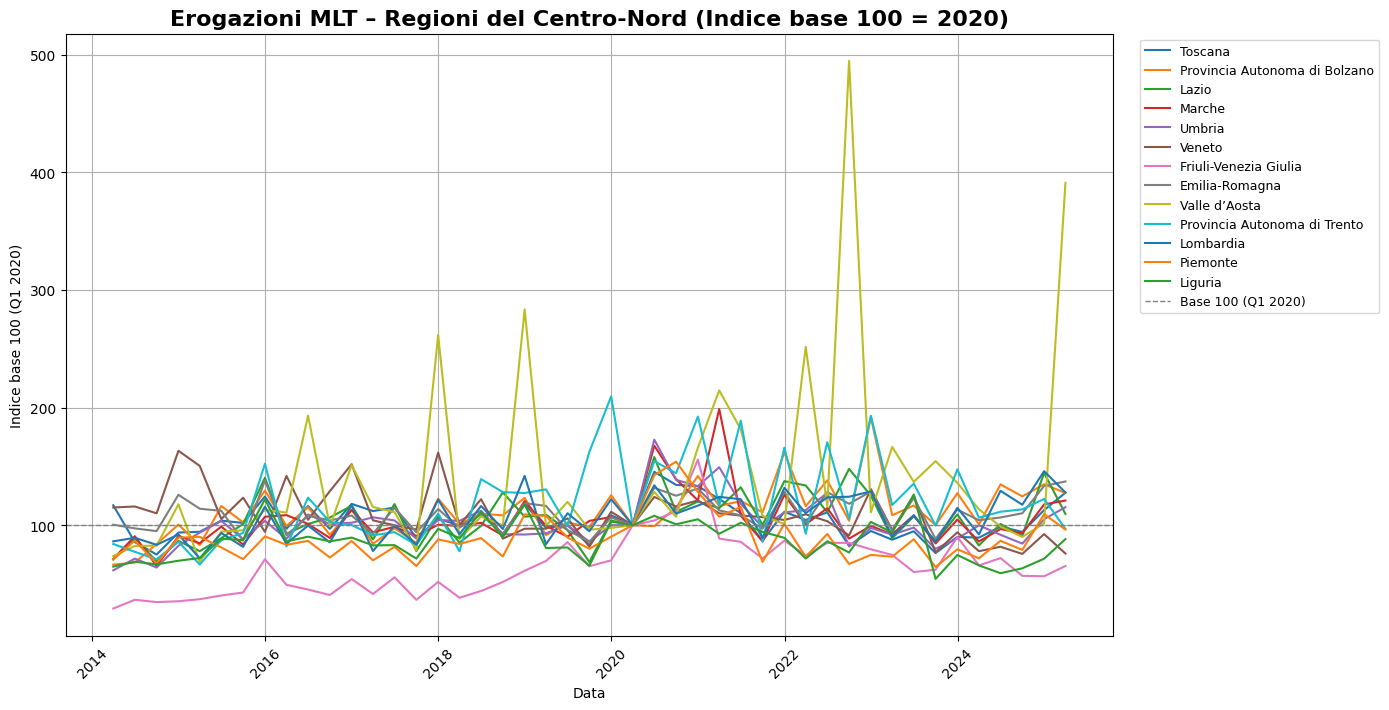

In [32]:
import matplotlib.pyplot as plt

# Copia e calcola base 100 rispetto al primo valore del 2020 per ogni regione
df_base100 = centronord_df.copy()

# Ordina per data e seleziona primo valore disponibile ≥ 2020 per ogni regione
base_2020 = df_base100[df_base100['DATA_OSS'] >= '2020-01-01'] \
    .sort_values('DATA_OSS') \
    .groupby('REGIONE').first()

# Calcolo indice base 100
def normalizza_base100(row):
    base = base_2020.loc[row['REGIONE']]['VALORE_MLD']
    return (row['VALORE_MLD'] / base) * 100 if base > 0 else None

df_base100['INDICE_2020'] = df_base100.apply(normalizza_base100, axis=1)

# Lineplot sovrapposto per tutte le regioni
plt.figure(figsize=(14, 7))
for regione in df_base100['REGIONE'].unique():
    subset = df_base100[df_base100['REGIONE'] == regione]
    plt.plot(subset['DATA_OSS'], subset['INDICE_2020'], label=regione)

plt.axhline(100, color='gray', linestyle='--', linewidth=1, label='Base 100 (Q1 2020)')
plt.title('Erogazioni MLT – Regioni del Centro-Nord (Indice base 100 = 2020)', fontsize=16, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Indice base 100 (Q1 2020)')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


# Mezzogiorno VS CentroNord

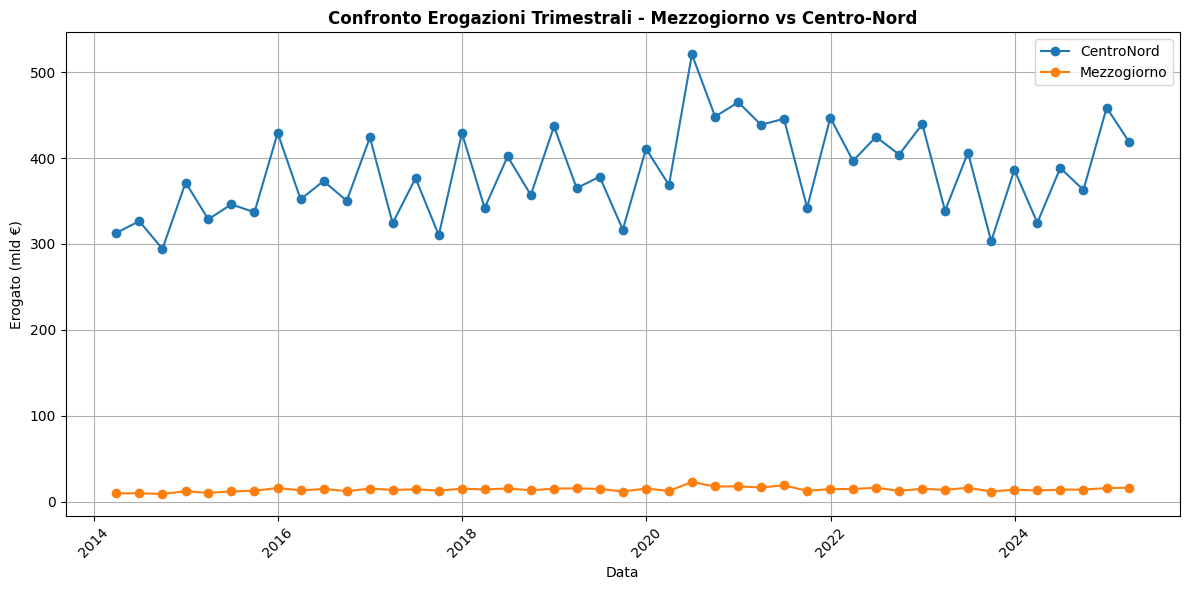

In [33]:
# Definizione codici LOC_CTP delle regioni del Mezzogiorno
regioni_mezzogiorno = [
    'ITF1', 'ITF2', 'ITF3', 'ITF4', 'ITF5', 'ITF6', 'ITG1', 'ITG2'
]

# Prepara un DataFrame con tutto il territorio nazionale
data['LOC_CTP'] = data['LOC_CTP'].astype(str)
data['TIPTASSO'] = data['TIPTASSO'].astype(str)
data['DESINV'] = data['DESINV'].astype(str)
data['ENTE_SEGN'] = data['ENTE_SEGN'].astype(str)

# Filtro per le condizioni rilevanti
filtered_df = data[
    (data['TIPTASSO'] == '10000') &
    (data['DESINV'] == '997') &
    (data['ENTE_SEGN'] == '1070001')
].copy()

# Aggiunge indicatore geografico
filtered_df['AREA'] = filtered_df['LOC_CTP'].apply(
    lambda x: 'Mezzogiorno' if x in regioni_mezzogiorno else 'CentroNord'
)

# Converte valori e date
filtered_df['VALORE'] = filtered_df['VALORE'].astype('int64') * 1000
filtered_df['VALORE_MLD'] = filtered_df['VALORE'] / 1e9
filtered_df['DATA_OSS'] = pd.to_datetime(filtered_df['DATA_OSS'])

# Raggruppa per area e trimestre
confronto_df = filtered_df.groupby(['DATA_OSS', 'AREA'])['VALORE_MLD'].sum().reset_index()

# Pivot per confronto diretto
pivot_df = confronto_df.pivot(index='DATA_OSS', columns='AREA', values='VALORE_MLD')

# Lineplot
plt.figure(figsize=(12, 6))
for area in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[area], marker='o', label=area)

plt.title('Confronto Erogazioni Trimestrali - Mezzogiorno vs Centro-Nord', fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Erogato (mld €)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


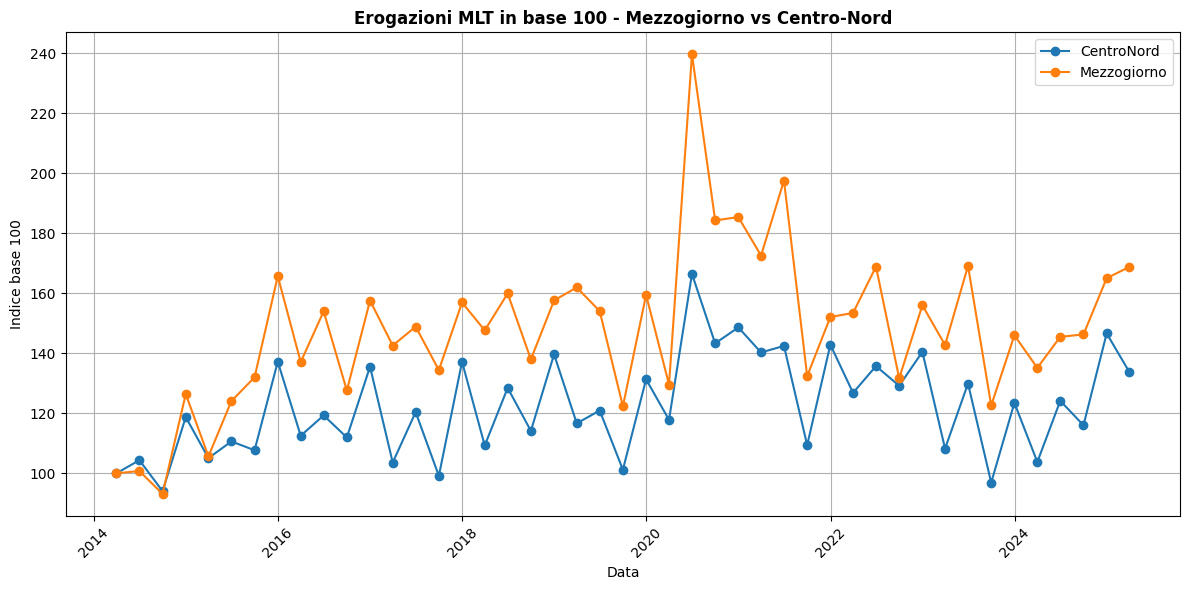

In [34]:
# Calcolo base 100: dividiamo ogni valore per il primo valore della serie e moltiplichiamo per 100
base100_df = pivot_df.copy()

for col in base100_df.columns:
    base_value = base100_df[col].iloc[0]
    base100_df[col] = (base100_df[col] / base_value) * 100

# Grafico in base 100
plt.figure(figsize=(12, 6))
for area in base100_df.columns:
    plt.plot(base100_df.index, base100_df[area], marker='o', label=area)

plt.title('Erogazioni MLT in base 100 - Mezzogiorno vs Centro-Nord', fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Indice base 100')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


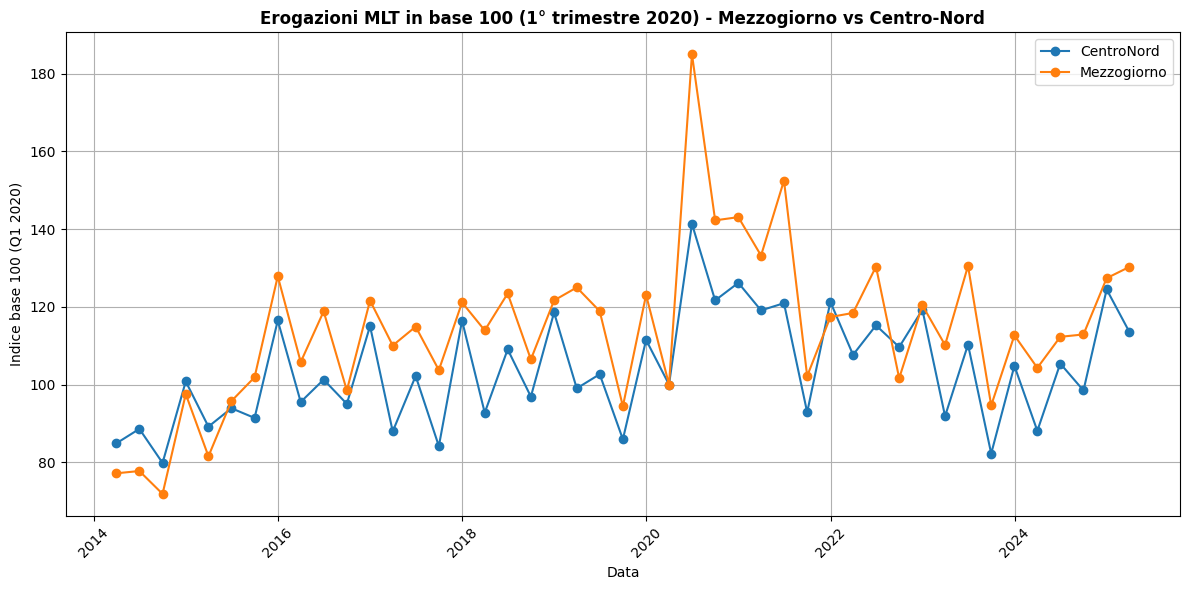

In [35]:
# Filtro primo trimestre 2020
base_2020 = pivot_df.loc[pivot_df.index >= '2020-01-01'].iloc[0]

# Normalizza base 100
base100_df = pivot_df.copy()
for col in base100_df.columns:
    base100_df[col] = (base100_df[col] / base_2020[col]) * 100

plt.figure(figsize=(12, 6))
for area in base100_df.columns:
    plt.plot(base100_df.index, base100_df[area], marker='o', label=area)

plt.title('Erogazioni MLT in base 100 (1° trimestre 2020) - Mezzogiorno vs Centro-Nord', fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Indice base 100 (Q1 2020)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



## Finalità

In [36]:
# Filtra solo i DESINV rilevanti
codici_interesse = ['10', '110', '120', '20', '212', '40', '50', '70', '80', '90',
                    '902', '905', '909', '912', '914', '916', '996', '997', '998']

df_invest = data[data['DESINV'].astype(str).isin(codici_interesse)].copy()

# Conversioni
df_invest['DATA_OSS'] = pd.to_datetime(df_invest['DATA_OSS'])
df_invest['VALORE'] = df_invest['VALORE'].astype('int64') * 1000  # se espresso in migliaia
df_invest['VALORE_MLD'] = df_invest['VALORE'] / 1e9

# Mappa a categoria sintetica
mappa_categoria = {
    '10': 'Costruzioni - Abitazioni',
    '212': 'Prestiti acquisto abitazioni',
    '70': 'Acquisto abitazioni (famiglie)',
    '80': 'Acquisto abitazioni (altri)',
    '914': 'Acquisto immobili diversi (famiglie)',

    '20': 'Costruzioni - Fabbricati rurali',
    '902': 'Costruzioni - Non residenziali',
    '912': 'Costruzioni - Altre',
    '40': 'Opere del genio civile',

    '50': 'Macchine e attrezzature (rurali)',
    '905': 'Macchine e attrezzature',

    '90': 'Immobili rurali',
    '909': 'Altri immobili',
    '916': 'Investimenti diversi',

    '120': 'Investimenti finanziari',
    '110': 'Beni durevoli famiglie',
    '996': 'Totale destinazioni agrarie',
    '997': 'Tutte le finalità',
    '998': 'Residuali o diverse'
}

df_invest['CATEGORIA'] = df_invest['DESINV'].astype(str).map(mappa_categoria)


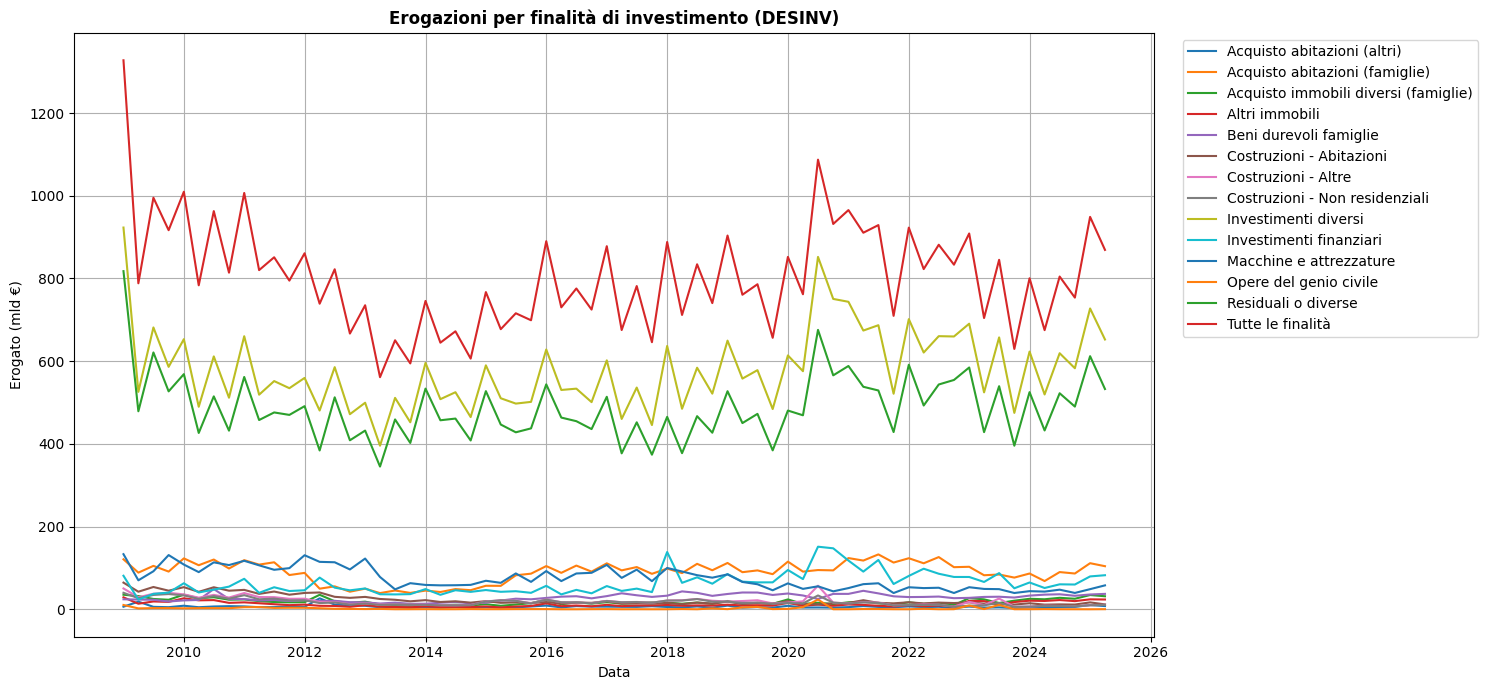

In [37]:
import matplotlib.pyplot as plt

df_grouped = df_invest.groupby(['DATA_OSS', 'CATEGORIA'])['VALORE_MLD'].sum().unstack()

# Lineplot
plt.figure(figsize=(15, 7))
for cat in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[cat], label=cat)

plt.title('Erogazioni per finalità di investimento (DESINV)', fontweight='bold')
plt.ylabel('Erogato (mld €)')
plt.xlabel('Data')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### grafico senza 110 212 70 80 914 996 997 998

Perfetto, se vuoi generare un grafico delle erogazioni per finalità di investimento escludendo le seguenti voci:

110 – Beni durevoli famiglie

212 – Prestiti per acquisto abitazioni

70, 80, 914 – Acquisto abitazioni (famiglie e altri)

996, 997, 998 – Aggregati totali e residuali

allora manteniamo solo le finalità non-finanziarie e non-residenziali reali, come costruzioni produttive, immobili rurali, macchinari, ecc.


🧠 Cosa mostra il grafico
Le erogazioni con finalità produttive e reali, escluse le componenti abitative e famigliari.

Può rivelare dove si concentra il credito per investimenti strutturali (macchinari, immobili industriali, opere civili, ecc.).

È utile per analizzare il ruolo del credito d’impresa e l’attivazione di fondi legati a investimenti produttivi (PNRR, ZES, industria, agricoltura, ecc.).

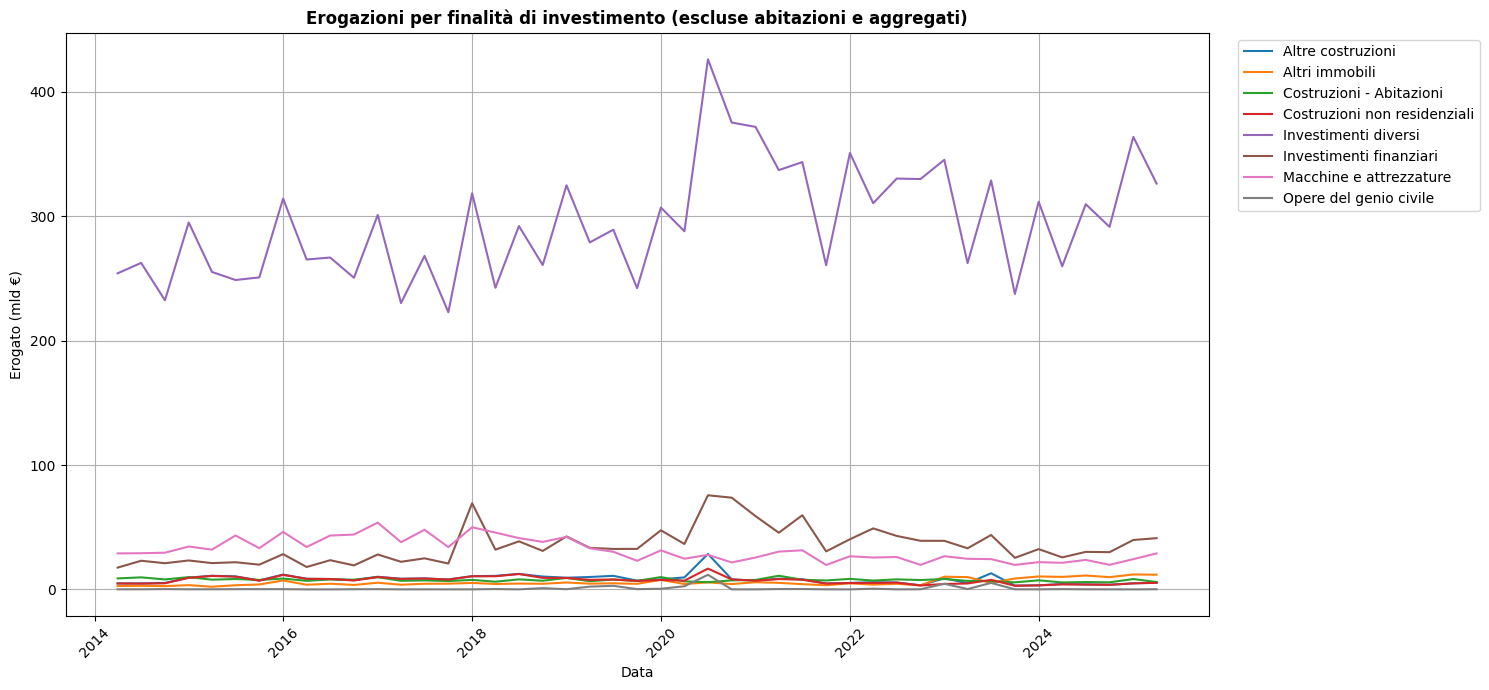

In [38]:
import matplotlib.pyplot as plt

# Codici da escludere
codici_esclusi = ['110', '212', '70', '80', '914', '996', '997', '998']

# Filtra solo i DESINV rilevanti, escludendo quelli specificati
df_filtrato = data[
    (~data['DESINV'].astype(str).isin(codici_esclusi)) &
    (data['TIPTASSO'].astype(str) == '10000') &  # Tasso aggregato
    (data['ENTE_SEGN'].astype(str) == '1070001')  # Fonte ufficiale
].copy()

# Conversioni
df_filtrato['DATA_OSS'] = pd.to_datetime(df_filtrato['DATA_OSS'])
df_filtrato['VALORE'] = df_filtrato['VALORE'].astype('int64') * 1000
df_filtrato['VALORE_MLD'] = df_filtrato['VALORE'] / 1e9

# Mappa sintetica per le finalità residue
mappa_categoria = {
    '10': 'Costruzioni - Abitazioni',
    '20': 'Fabbricati rurali',
    '40': 'Opere del genio civile',
    '50': 'Macchine e mezzi rurali',
    '90': 'Immobili rurali',
    '902': 'Costruzioni non residenziali',
    '905': 'Macchine e attrezzature',
    '909': 'Altri immobili',
    '912': 'Altre costruzioni',
    '916': 'Investimenti diversi',
    '120': 'Investimenti finanziari'
}
df_filtrato['CATEGORIA'] = df_filtrato['DESINV'].astype(str).map(mappa_categoria)

# Aggrega
df_grouped = df_filtrato.groupby(['DATA_OSS', 'CATEGORIA'])['VALORE_MLD'].sum().unstack()

# Lineplot
plt.figure(figsize=(15, 7))
for col in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[col], label=col)

plt.title('Erogazioni per finalità di investimento (escluse abitazioni e aggregati)', fontweight='bold')
plt.ylabel('Erogato (mld €)')
plt.xlabel('Data')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


Ottimo! Il grafico che hai generato mostra le **erogazioni per finalità di investimento** (variabile `DESINV`) **escludendo le componenti abitative e aggregati totali**, come richiesto.

Ecco un’analisi sintetica del contenuto e alcune proposte di miglioramento:

---

## 📊 **Analisi del grafico**

### ✅ **Serie incluse (finalità rilevanti)**

| Finalità                         | Codice DESINV | Osservazioni                                                   |
| -------------------------------- | ------------- | -------------------------------------------------------------- |
| **Investimenti diversi**         | 916           | Domina il grafico, ma è un residuo (molto aggregato)           |
| **Macchine e attrezzature**      | 905           | Seconda per importanza, stabile con lieve discesa nel 2021–23  |
| **Investimenti finanziari**      | 120           | Volatili, picchi marcati (es. 2018, 2020)                      |
| **Costruzioni non residenziali** | 902           | Regolare e stabile, possibile proxy per immobiliare produttivo |
| **Opere del genio civile**       | 40            | Marginale, ma costante                                         |
| **Altre costruzioni**            | 912           | Quota residuale, non ciclica                                   |
| **Altri immobili**               | 909           | Marginale e stabile                                            |

### 📈 **Considerazioni**

* Il dato **dominante (“Investimenti diversi”) potrebbe distorcere la scala** del grafico, impedendo una lettura fine delle altre serie.
* Sarebbe utile **rimuovere o isolare la voce 916**, che sembra una **categoria residuale poco informativa** (e di fatto aggrega altri sottogruppi).
* Le **erogazioni per “macchine e attrezzature”** sono più rilevanti e tracciabili nel tempo, probabilmente connesse all’**industria, agricoltura o incentivi 4.0**.

---

## ✍️ Testo per commento in report

> Il grafico mostra l’andamento delle erogazioni MLT per le principali finalità di investimento **escludendo le componenti abitative e familiari**. Si evidenzia il peso significativo della voce **“Investimenti diversi”**, che ingloba una varietà di destinazioni non classificate in modo puntuale. Al netto di questa, la quota più rilevante riguarda gli investimenti in **macchinari e attrezzature**, seguiti da erogazioni per immobili non residenziali e opere del genio civile. La dinamica è relativamente stabile, con variazioni che riflettono interventi pubblici straordinari (es. nel 2020) e incentivi settoriali.

---

## ✅ Suggerimenti per miglioramento visivo

1. **Rimuovere “Investimenti diversi (916)” dal grafico** o isolarla in un grafico a parte.
2. **Normalizzare in base 100 (es. 2020)** per analisi relativa.
3. **Usare scala logaritmica sull’asse Y** o due assi (twin y-axis) se vuoi mantenere tutte le serie ma evidenziare meglio le piccole.
4. **Stacked area plot** per mostrare la composizione percentuale nel tempo.

---

## Vuoi che ti generi il codice per:

* Escludere `DESINV = 916` dal grafico?
* Rifare lo stesso grafico in **base 100**?
* Mostrare solo le **top 5 finalità** più rilevanti?

Posso farlo in pochi secondi.


### solo alle imprese

✅ 1. Isolare i codici DESINV riferibili alle imprese
Ti propongo di includere solo le voci tipiche dell’attività d’impresa, escludendo le finalità familiari e residenziali:

Codice	Finalità	Motivazione inclusione
20	Costruzioni - fabbricati rurali	Agricoltura/industria
40	Opere del genio civile	Costruzioni pubbliche
50	Macchine, attrezzature, mezzi rurali	Investimenti produttivi
902	Costruzioni non residenziali	Fabbricati industriali
905	Macchine, attrezzature, mezzi di trasporto	Industria, logistica
909	Acquisto altri immobili	Commerciale/produttivo
912	Costruzioni diverse da abitazioni	Capannoni, depositi
916	Destinazioni diverse da acquisto immobili	Residuale d’impresa

(Escludiamo 10, 70, 80, 212, 914 = famiglie/abitazioni; 120 e 998 = finanziari/residuali.)

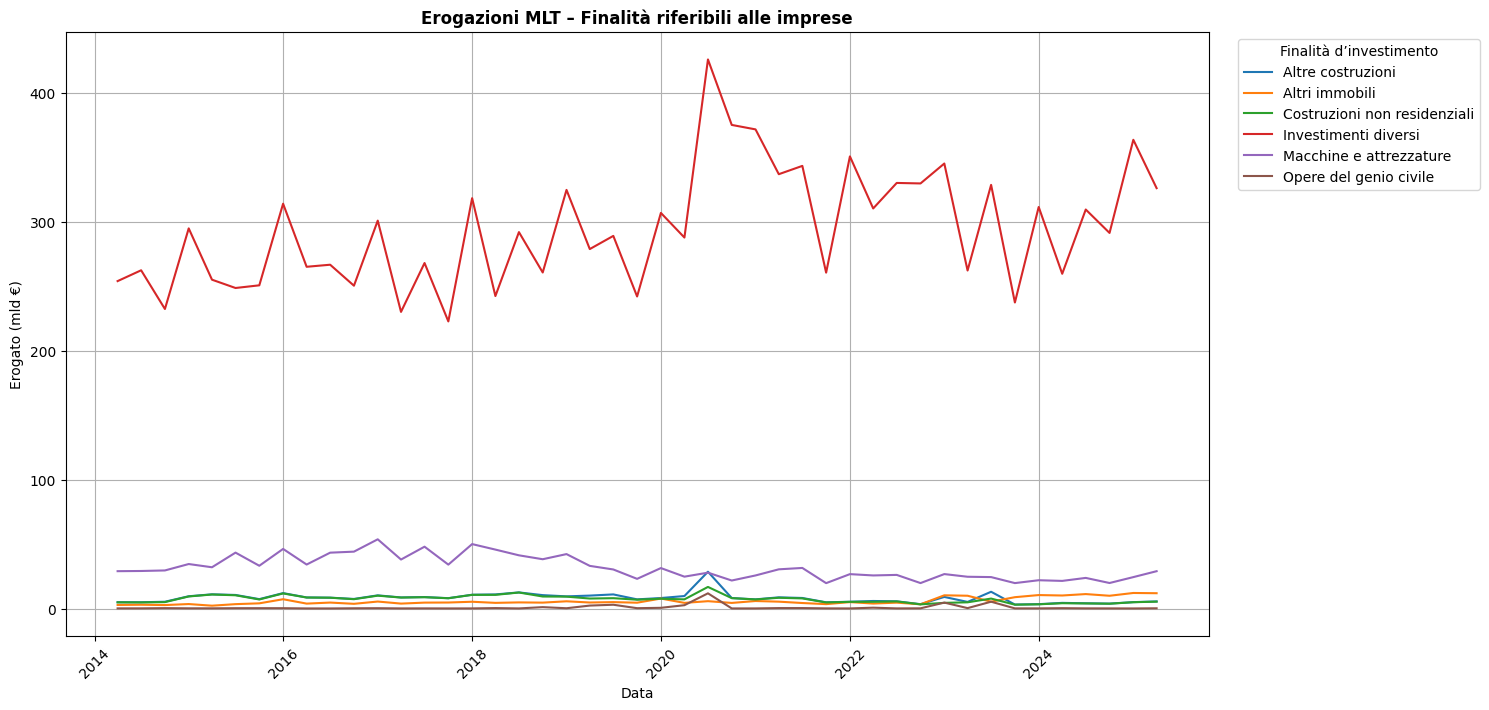

In [39]:
import matplotlib.pyplot as plt

# Codici destinazioni d’investimento riconducibili alle imprese
desinv_imprese = ['20', '40', '50', '902', '905', '909', '912', '916']

# Filtra
df_imprese = data[
    (data['DESINV'].astype(str).isin(desinv_imprese)) &
    (data['TIPTASSO'].astype(str) == '10000') &  # Tasso aggregato
    (data['ENTE_SEGN'].astype(str) == '1070001')  # Fonte Banca d’Italia
].copy()

# Conversioni
df_imprese['VALORE'] = df_imprese['VALORE'].astype('int64') * 1000
df_imprese['VALORE_MLD'] = df_imprese['VALORE'] / 1e9
df_imprese['DATA_OSS'] = pd.to_datetime(df_imprese['DATA_OSS'])

# Mappa sintetica
mappa_categoria_imprese = {
    '20': 'Fabbricati rurali',
    '40': 'Opere del genio civile',
    '50': 'Macchine rurali',
    '902': 'Costruzioni non residenziali',
    '905': 'Macchine e attrezzature',
    '909': 'Altri immobili',
    '912': 'Altre costruzioni',
    '916': 'Investimenti diversi'
}
df_imprese['CATEGORIA'] = df_imprese['DESINV'].astype(str).map(mappa_categoria_imprese)

# Aggrega
df_grouped = df_imprese.groupby(['DATA_OSS', 'CATEGORIA'])['VALORE_MLD'].sum().unstack()

# Plot
plt.figure(figsize=(15, 7))
for col in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[col], label=col)

plt.title('Erogazioni MLT – Finalità riferibili alle imprese', fontweight='bold')
plt.ylabel('Erogato (mld €)')
plt.xlabel('Data')
plt.grid(True)
plt.legend(title='Finalità d’investimento', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


 Il grafico evidenzia chiaramente una distorsione dovuta alla voce "Investimenti diversi" (DESINV = 916), che:

Domina visivamente il grafico, comprimendo le altre serie,

È una categoria residuale o poco informativa,

Può includere destinazioni eterogenee e non confrontabili nel tempo.

🧠 Considerazioni sull’analisi
✅ Quando i dati sono utili:
Le finalità specifiche come macchine e attrezzature, costruzioni non residenziali, opere del genio civile sono interpretabili e coerenti con l’attività d’impresa.

Offrono una lettura interessante se:

disaggregate per territorio (es. Mezzogiorno vs Centro-Nord),

o normalizzate in base 100.

⚠️ Quando i dati sono meno significativi:
Se categorie ampie e residuali (come 916) assorbono la gran parte del valore, l’analisi perde dettaglio.

Se le erogazioni sono generate da automatismi bancari o riclassificazioni incoerenti (es. campagne promozionali, rinegoziazioni, operazioni contabili non omogenee).

✅ Cosa puoi fare adesso?
🔹 1. Escludere DESINV = 916 dal grafico
Per ottenere una lettura più utile delle sole finalità produttive chiare.

🔹 2. Analizzare in base 100 (es. rispetto al 2020)
Per evidenziare le dinamiche relative, non i livelli assoluti.

🔹 3. Focus territoriale
Visualizzare le stesse finalità solo per Mezzogiorno o per singole regioni.

✍️ Se vuoi un testo da includere in nota/report:
L’analisi delle erogazioni per finalità d’investimento riferibili alle imprese mostra una forte prevalenza della voce “Investimenti diversi”, che limita la leggibilità delle altre categorie. Al netto di questa, le serie più significative riguardano le costruzioni non residenziali e i macchinari. Tuttavia, la significatività statistica e contabile della voce residuale suggerisce cautela nell’interpretazione. Risulta più efficace concentrarsi sulle finalità con significato economico preciso, eventualmente disaggregate per territorio o settore produttivo.

### Erogazioni riferibili alle imprese, escludendo la voce DESINV = 916 ("Investimenti diversi"), così da ottenere una rappresentazione più leggibile e significativa.

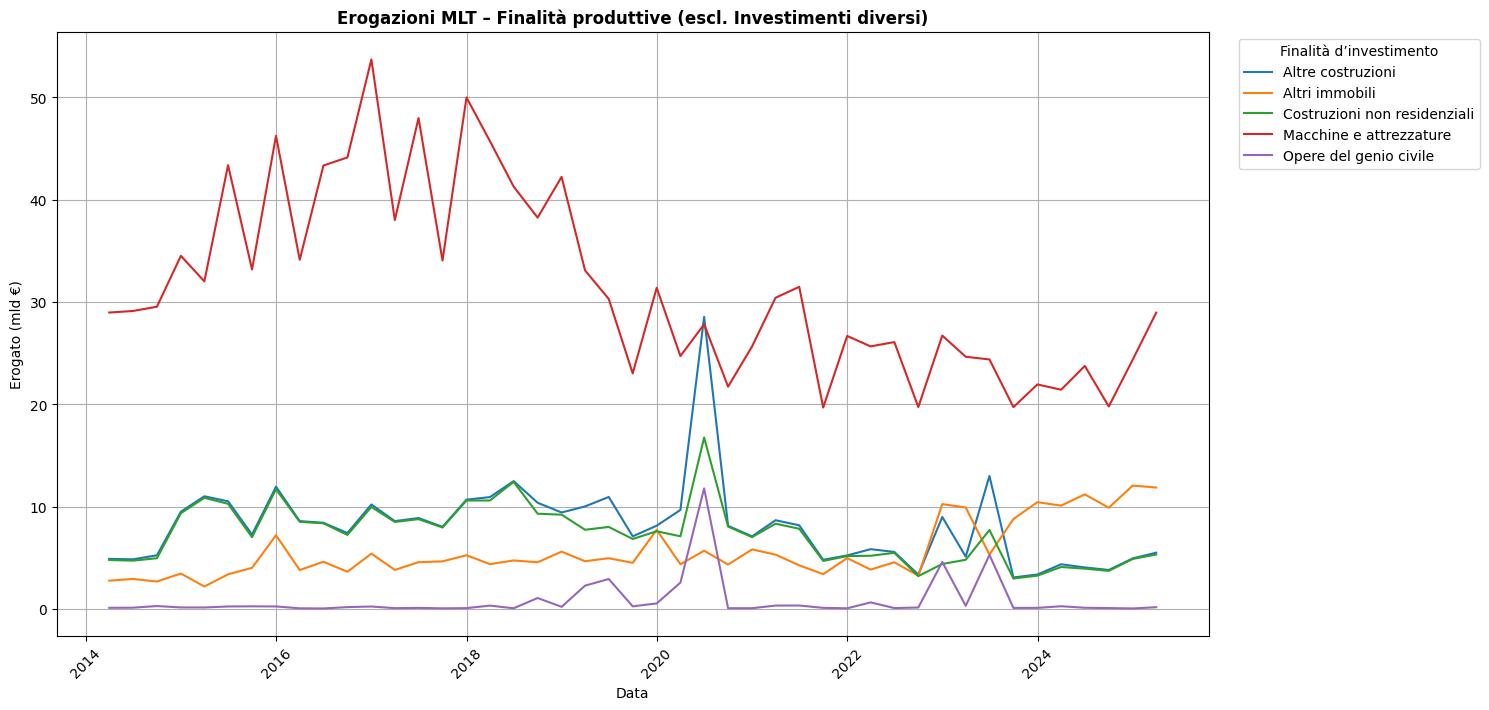

In [40]:
import matplotlib.pyplot as plt

# Codici d'investimento riferibili alle imprese, **escludendo 916**
desinv_imprese_senza_916 = ['20', '40', '50', '902', '905', '909', '912']

# Filtro
df_imprese_filtrato = data[
    (data['DESINV'].astype(str).isin(desinv_imprese_senza_916)) &
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversioni
df_imprese_filtrato['VALORE'] = df_imprese_filtrato['VALORE'].astype('int64') * 1000
df_imprese_filtrato['VALORE_MLD'] = df_imprese_filtrato['VALORE'] / 1e9
df_imprese_filtrato['DATA_OSS'] = pd.to_datetime(df_imprese_filtrato['DATA_OSS'])

# Mappatura sintetica
mappa_categoria_imprese_senza_916 = {
    '20': 'Fabbricati rurali',
    '40': 'Opere del genio civile',
    '50': 'Macchine rurali',
    '902': 'Costruzioni non residenziali',
    '905': 'Macchine e attrezzature',
    '909': 'Altri immobili',
    '912': 'Altre costruzioni'
}
df_imprese_filtrato['CATEGORIA'] = df_imprese_filtrato['DESINV'].astype(str).map(mappa_categoria_imprese_senza_916)

# Aggrega
df_grouped = df_imprese_filtrato.groupby(['DATA_OSS', 'CATEGORIA'])['VALORE_MLD'].sum().unstack()

# Plot
plt.figure(figsize=(15, 7))
for col in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[col], label=col)

plt.title('Erogazioni MLT – Finalità produttive (escl. Investimenti diversi)', fontweight='bold')
plt.ylabel('Erogato (mld €)')
plt.xlabel('Data')
plt.grid(True)
plt.legend(title='Finalità d’investimento', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


in assenza della variabile SET_CTP, possiamo comunque escludere con buona approssimazione le erogazioni a MLT verso famiglie utilizzando i codici DESINV tipici delle finalità familiari o abitative

| Codice | Finalità                                               |
| ------ | ------------------------------------------------------ |
| `10`   | Costruzioni - abitazioni                               |
| `70`   | Acquisto immobili - abitazioni (famiglie consumatrici) |
| `80`   | Acquisto immobili - abitazioni (altri soggetti)        |
| `212`  | Prestiti per acquisto abitazioni                       |
| `914`  | Acquisto immobili diversi da abitazioni (famiglie)     |
| `110`  | Beni durevoli (famiglie consumatrici)                  |


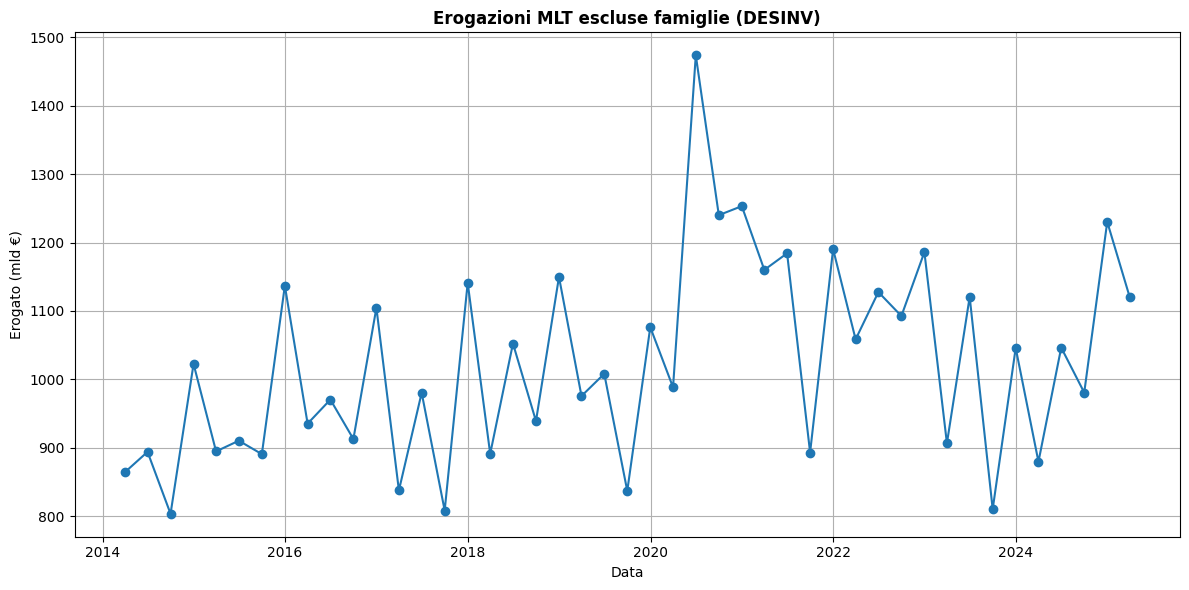

In [41]:
# Codici DESINV tipici delle famiglie
desinv_famiglie = ['10', '70', '80', '212', '914', '110']

# Filtro: escludiamo le famiglie
df_no_famiglie = data[
    (~data['DESINV'].astype(str).isin(desinv_famiglie)) &
    (data['TIPTASSO'].astype(str) == '10000') &         # Tasso aggregato
    (data['ENTE_SEGN'].astype(str) == '1070001') &      # Fonte ufficiale
    (data['DURORI'].astype(str).isin(['18', '36', '60', '120']))  # MLT
].copy()

# Conversioni
df_no_famiglie['VALORE'] = df_no_famiglie['VALORE'].astype('int64') * 1000
df_no_famiglie['VALORE_MLD'] = df_no_famiglie['VALORE'] / 1e9
df_no_famiglie['DATA_OSS'] = pd.to_datetime(df_no_famiglie['DATA_OSS'])

# Aggrega per trimestre
df_agg = df_no_famiglie.groupby('DATA_OSS')['VALORE_MLD'].sum().reset_index()

# Lineplot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_agg['DATA_OSS'], df_agg['VALORE_MLD'], marker='o')
plt.title('Erogazioni MLT escluse famiglie (DESINV)', fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Erogato (mld €)')
plt.grid(True)
plt.tight_layout()
plt.show()



quanto pesano queste categorie escluse sul totale 997

Calcolare, per ciascun trimestre:

Quota famiglie
=
Erogazioni con DESINV in [10, 70, 80, 212, 914, 110]
Erogazioni totali (DESINV = 997)
Quota famiglie= 
Erogazioni totali (DESINV = 997)
Erogazioni con DESINV in [10, 70, 80, 212, 914, 110]
​
 
Espressa in percentuale.


La quota potrebbe essere stabile tra 40% e 60%, ma:

più alta nei periodi di boom immobiliare o mutui agevolati,

più bassa in fasi di rilancio industriale (es. incentivi 4.0, PNRR).

In [42]:
# Codici da considerare come "famiglie"
desinv_famiglie = ['10', '70', '80', '212', '914', '110']

# Filtro tasso aggregato e fonte ufficiale
df_filtered = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversioni
df_filtered['DATA_OSS'] = pd.to_datetime(df_filtered['DATA_OSS'])
df_filtered['VALORE'] = df_filtered['VALORE'].astype('int64') * 1000
df_filtered['VALORE_MLD'] = df_filtered['VALORE'] / 1e9

# Totale erogazioni (DESINV = 997)
totali = df_filtered[df_filtered['DESINV'].astype(str) == '997'] \
    .groupby('DATA_OSS')['VALORE_MLD'].sum() \
    .rename('TOTALE')

# Erogazioni famiglie (DESINV ∈ codici familiari)
famiglie = df_filtered[df_filtered['DESINV'].astype(str).isin(desinv_famiglie)] \
    .groupby('DATA_OSS')['VALORE_MLD'].sum() \
    .rename('FAMIGLIE')

# Merge
df_quota = pd.concat([totali, famiglie], axis=1).fillna(0)
df_quota['QUOTA_%'] = (df_quota['FAMIGLIE'] / df_quota['TOTALE']) * 100


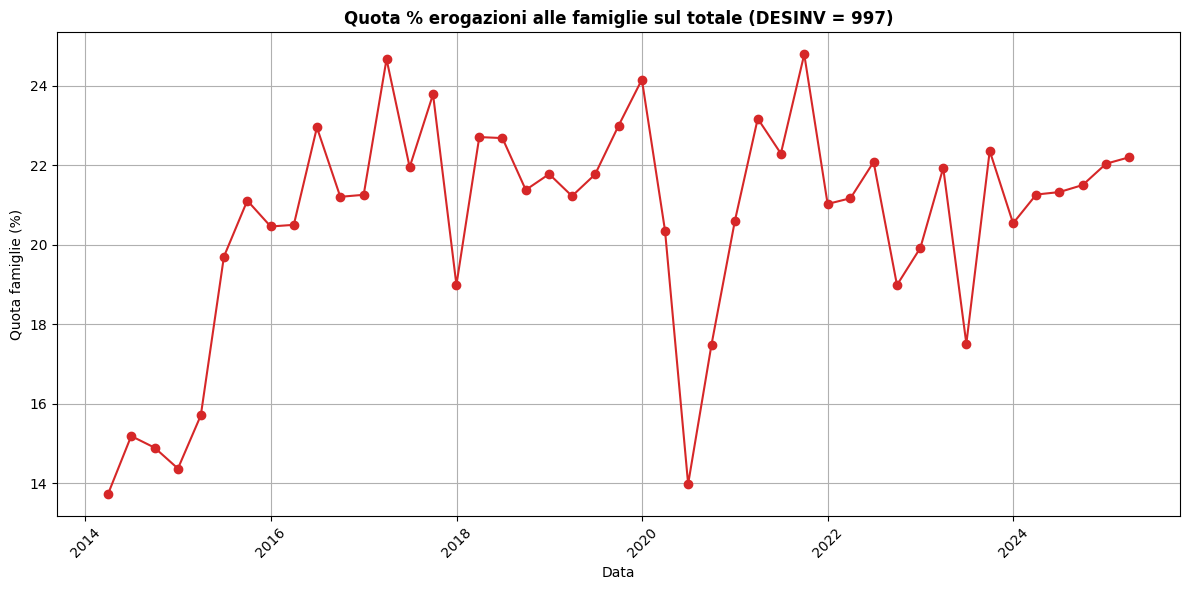

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_quota.index, df_quota['QUOTA_%'], marker='o', color='tab:red')
plt.title('Quota % erogazioni alle famiglie sul totale (DESINV = 997)', fontweight='bold')
plt.ylabel('Quota famiglie (%)')
plt.xlabel('Data')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Perfetto, il grafico mostra chiaramente la **quota % trimestrale delle erogazioni MLT alle famiglie** rispetto al totale (DESINV = 997). Ecco una sintesi interpretativa.

---

## 📊 **Analisi della quota famiglie sul totale MLT**

### ✅ **Trend osservato:**

* **2014–2015:** le famiglie assorbono in media il **14–16%** delle erogazioni.
* **2016–2019:** **graduale aumento** con valori oscillanti tra **20% e 25%**.
* **2020:** shock COVID → crollo della quota in alcuni trimestri fino a **\~14%**, per effetto delle massicce erogazioni garantite alle imprese.
* **2021–2025:** la quota si stabilizza tra **20% e 24%**, con fluttuazioni legate a fattori stagionali e di policy.

---

### 🧠 **Interpretazione economica**

> Le famiglie rappresentano in media **un quinto del totale delle erogazioni a medio-lungo termine**. Questo conferma che **la quota preponderante del credito MLT è rivolta a soggetti diversi dalle famiglie consumatrici**: imprese, enti, professionisti o produttori agricoli.

### ⛔ **Eventi anomali**

* I picchi e crolli attorno al 2020 riflettono l'effetto della pandemia:

  * **forte espansione del credito d’impresa garantito**,
  * **ridotta domanda residenziale nei trimestri critici**.

---

## ✍️ Testo per report

> La quota di erogazioni MLT destinate a famiglie, identificata tramite specifici codici `DESINV`, si è mantenuta tra il 20% e il 25% del totale dal 2016 in poi, con una flessione temporanea nel 2020 per effetto della concentrazione delle misure emergenziali sulle imprese. Questo conferma la validità dell’approccio di esclusione delle categorie familiari per ottenere un proxy del credito rivolto all’economia produttiva.

---

## ✅ Prossimi passi possibili

* **Visualizzare la quota complementare (non famiglie)** per raffronto.
* **Normalizzare i valori assoluti (base 100 o var. YoY)**.
* **Esportare i valori in CSV o tabella**.
* **Segmentare per area geografica** (es. quota famiglie in Mezzogiorno vs Centro-Nord).

Vuoi uno di questi approfondimenti?


### grafico delle due macrocategorie in base 100 = 2020

In [44]:
# Definizione famiglie vs non famiglie, escluso anche 996 e 997
desinv_famiglie = ['10', '70', '80', '212', '914', '110']
categorie_escluse = ['997', '996']  # tutte le finalità + totale destinazioni agrarie

df_base['CATEGORIA'] = df_base['DESINV'].astype(str).apply(
    lambda x: 'Famiglie' if x in desinv_famiglie else ('Non famiglie' if x not in categorie_escluse else None)
)
df_base = df_base[df_base['CATEGORIA'].notna()]


import matplotlib.pyplot as plt

# Filtro: tasso aggregato e fonte ufficiale
df_base = data[
    (data['TIPTASSO'].astype(str) == '10000') &
    (data['ENTE_SEGN'].astype(str) == '1070001')
].copy()

# Conversioni
df_base['VALORE'] = df_base['VALORE'].astype('int64') * 1000
df_base['VALORE_MLD'] = df_base['VALORE'] / 1e9
df_base['DATA_OSS'] = pd.to_datetime(df_base['DATA_OSS'])

# Definizione famiglie vs non famiglie
desinv_famiglie = ['10', '70', '80', '212', '914', '110']
df_base['CATEGORIA'] = df_base['DESINV'].astype(str).apply(
    lambda x: 'Famiglie' if x in desinv_famiglie else ('Non famiglie' if x != '997' else None)
)
df_base = df_base[df_base['CATEGORIA'].notna()]  # esclude 997 e NaN

# Aggregazione per trimestre e categoria
df_agg = df_base.groupby(['DATA_OSS', 'CATEGORIA'])['VALORE_MLD'].sum().unstack()

# Base 100 = media del 2020
base_2020 = df_agg.loc[(df_agg.index >= '2020-01-01') & (df_agg.index < '2021-01-01')].mean()
df_base100 = (df_agg / base_2020) * 100

# Plot
plt.figure(figsize=(12, 6))
for cat in df_base100.columns:
    plt.plot(df_base100.index, df_base100[cat], marker='o', label=cat)

plt.axhline(100, color='gray', linestyle='--', linewidth=0.8)
plt.title('Erogazioni MLT in base 100 (2020) – Famiglie vs Non famiglie', fontweight='bold')
plt.ylabel('Indice base 100 (2020)')
plt.xlabel('Data')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'df_base' is not defined

Le famiglie hanno avuto un ruolo consistente e crescente nel periodo 2015–2021.

Il peso delle imprese non ha superato significativamente i valori del 2020, segnalando:

possibile cautela negli investimenti produttivi;

oppure trasformazione nella forma di finanziamento (es. leasing, autofinanziamento, breve termine).

L’indice non riflette pienamente la dinamica aggregata, perché i volumi assoluti sono diversi. Ma rende visibile la divergenza tendenziale tra categorie.

## DEF

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

def grafico_erogazioni(
    df, 
    desinv_list=None, 
    regioni_list=None, 
    facet=False, 
    base100=False,
    titolo='Erogazioni trimestrali'
):
    # Pre-elaborazione
    df = df.copy()
    df['DATA_OSS'] = pd.to_datetime(df['DATA_OSS'])
    df['VALORE'] = df['VALORE'].astype('int64') * 1000  # da migliaia a euro
    df['VALORE_MLD'] = df['VALORE'] / 1e9
    df['DESINV'] = df['DESINV'].astype(str)
    df['LOC_CTP'] = df['LOC_CTP'].astype(str)

    # Filtro per tasso e fonte
    df = df[
        (df['TIPTASSO'] == '10000') &
        (df['ENTE_SEGN'] == '1070001')
    ]

    # Applica filtri opzionali
    if desinv_list is not None:
        df = df[df['DESINV'].isin(desinv_list)]
    if regioni_list is not None:
        df = df[df['LOC_CTP'].isin(regioni_list)]

    # Mapping opzionale nomi regioni (usalo se serve)
    regioni_nomi = {
        'ITF1': 'Abruzzo', 'ITF2': 'Molise', 'ITF3': 'Campania',
        'ITF4': 'Puglia', 'ITF5': 'Basilicata', 'ITF6': 'Calabria',
        'ITG1': 'Sicilia', 'ITG2': 'Sardegna',
        'ITH10': 'Bolzano', 'ITH20': 'Trento', 'ITH3': 'Veneto',
        'ITH4': 'Friuli VG', 'ITH5': 'Emilia-Romagna',
        'ITI1': 'Toscana', 'ITI2': 'Umbria', 'ITI3': 'Marche',
        'ITI4': 'Lazio', 'ITC1': 'Piemonte', 'ITC2': 'Valle d’Aosta',
        'ITC3': 'Liguria', 'ITC4': 'Lombardia', 'IT': 'Italia'
    }
    df['REGIONE'] = df['LOC_CTP'].map(regioni_nomi).fillna(df['LOC_CTP'])

    # Aggregazione
    group_cols = ['DATA_OSS']
    if facet:
        group_cols.append('REGIONE')

    agg_df = df.groupby(group_cols)['VALORE_MLD'].sum().reset_index()

    # Normalizzazione base 100 (opzionale)
    if base100:
        if facet:
            base = agg_df[agg_df['DATA_OSS'] >= '2020-01-01'].sort_values('DATA_OSS').groupby('REGIONE').first()
            agg_df['BASE100'] = agg_df.apply(
                lambda row: (row['VALORE_MLD'] / base.loc[row['REGIONE']]['VALORE_MLD'] * 100) 
                if row['REGIONE'] in base.index else None, axis=1
            )
        else:
            base_val = agg_df[agg_df['DATA_OSS'] >= '2020-01-01'].sort_values('DATA_OSS')['VALORE_MLD'].iloc[0]
            agg_df['BASE100'] = agg_df['VALORE_MLD'] / base_val * 100

    # Plotting
    if facet:
        n = agg_df['REGIONE'].nunique()
        cols = 2
        rows = (n + 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 3.5), sharex=True)
        axes = axes.flatten()
        for i, regione in enumerate(sorted(agg_df['REGIONE'].unique())):
            subset = agg_df[agg_df['REGIONE'] == regione]
            yval = 'BASE100' if base100 else 'VALORE_MLD'
            axes[i].plot(subset['DATA_OSS'], subset[yval], marker='o')
            axes[i].set_title(regione, fontweight='bold')
            axes[i].grid(True)
            if i % 2 == 0:
                axes[i].set_ylabel('Indice base 100' if base100 else 'Erogato (mld €)')
        fig.suptitle(titolo, fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        yval = 'BASE100' if base100 else 'VALORE_MLD'
        plt.figure(figsize=(12, 6))
        plt.plot(agg_df['DATA_OSS'], agg_df[yval], marker='o')
        plt.title(titolo, fontweight='bold')
        # plt.xlabel('Data')
        plt.ylabel('Indice base 100' if base100 else 'Erogato (mld €)')
        plt.grid(True)
        # plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


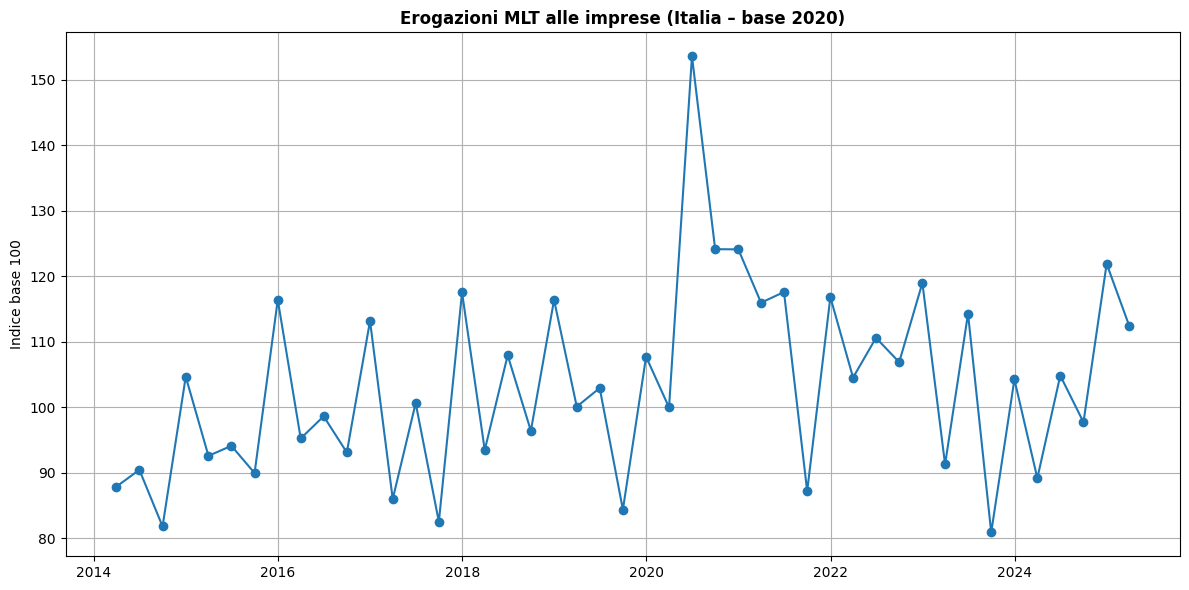

In [78]:
grafico_erogazioni(
    data, 
    desinv_list=['20', '40', '50', '90', '902', '905', '909', '912', '916'], 
    regioni_list=['IT'], 
    facet=False,
    base100=True,
    titolo='Erogazioni MLT alle imprese (Italia – base 2020)'
)


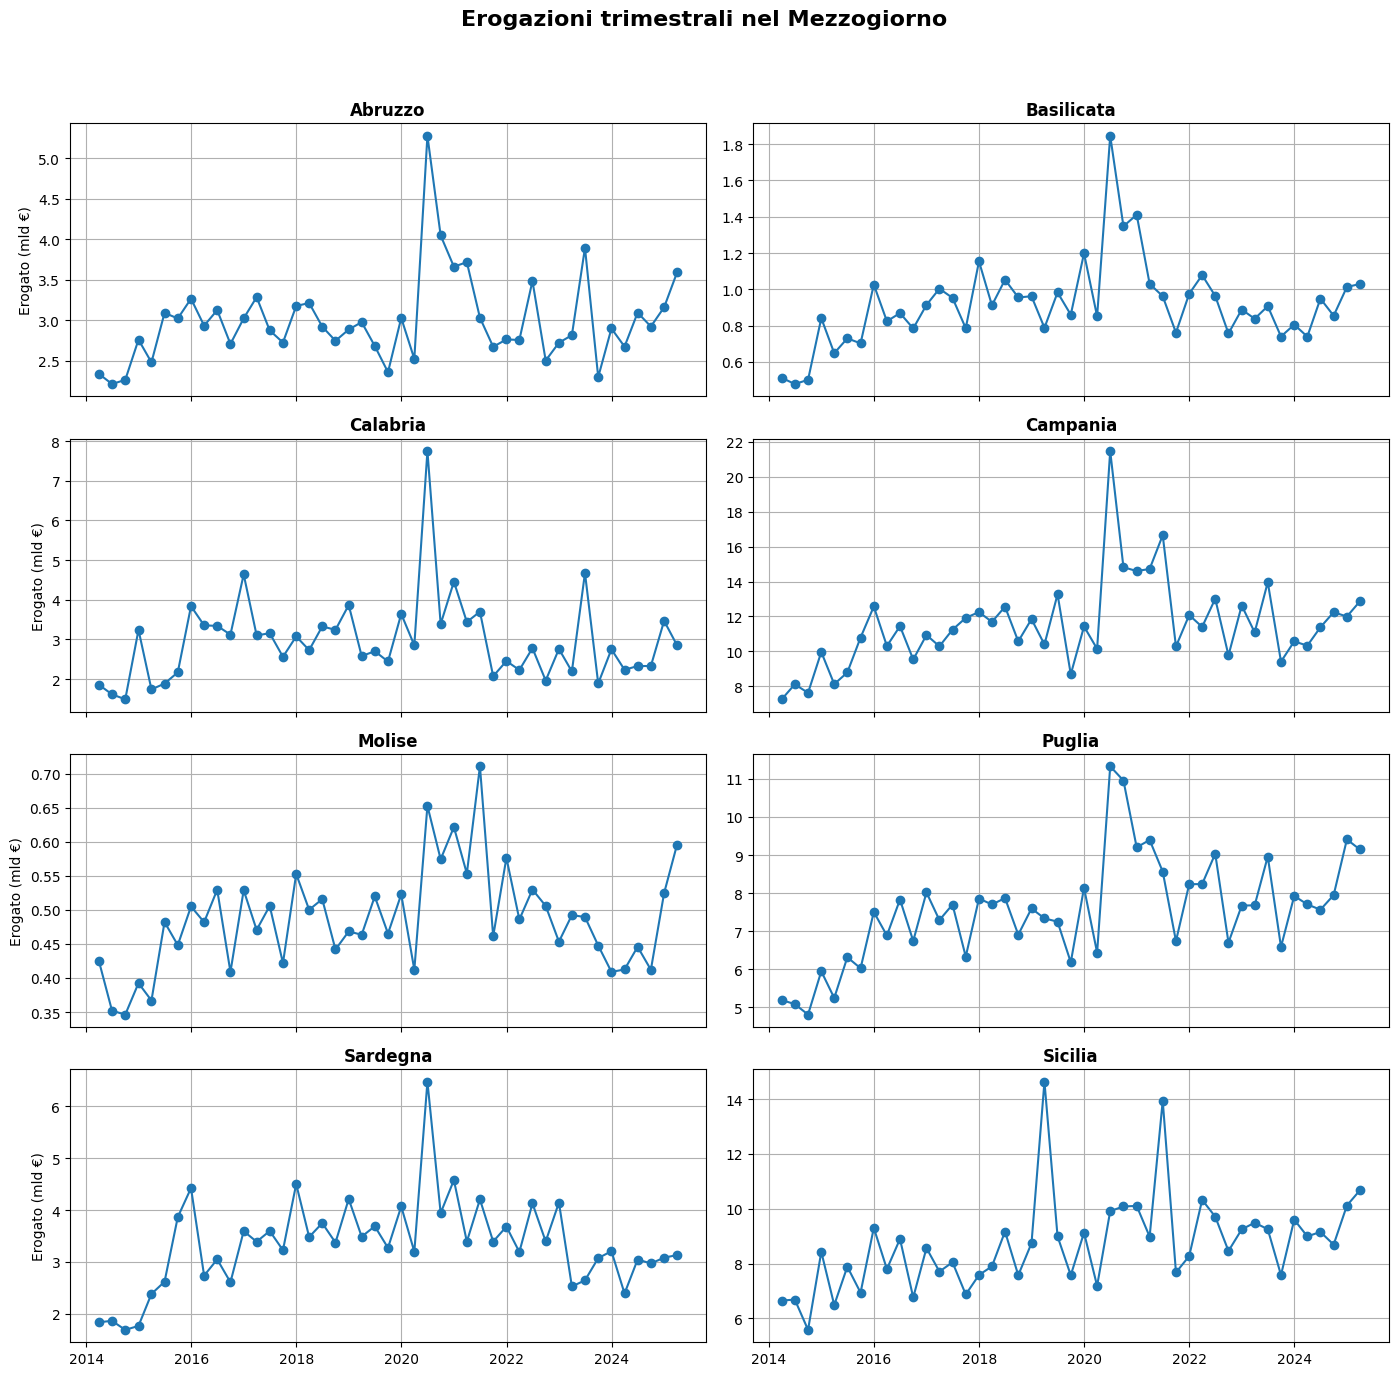

In [79]:
regioni_mezzogiorno = ['ITF1','ITF2','ITF3','ITF4','ITF5','ITF6','ITG1','ITG2']

grafico_erogazioni(
    data, 
    regioni_list=regioni_mezzogiorno, 
    facet=True,
    base100=False,
    titolo='Erogazioni trimestrali nel Mezzogiorno'
)


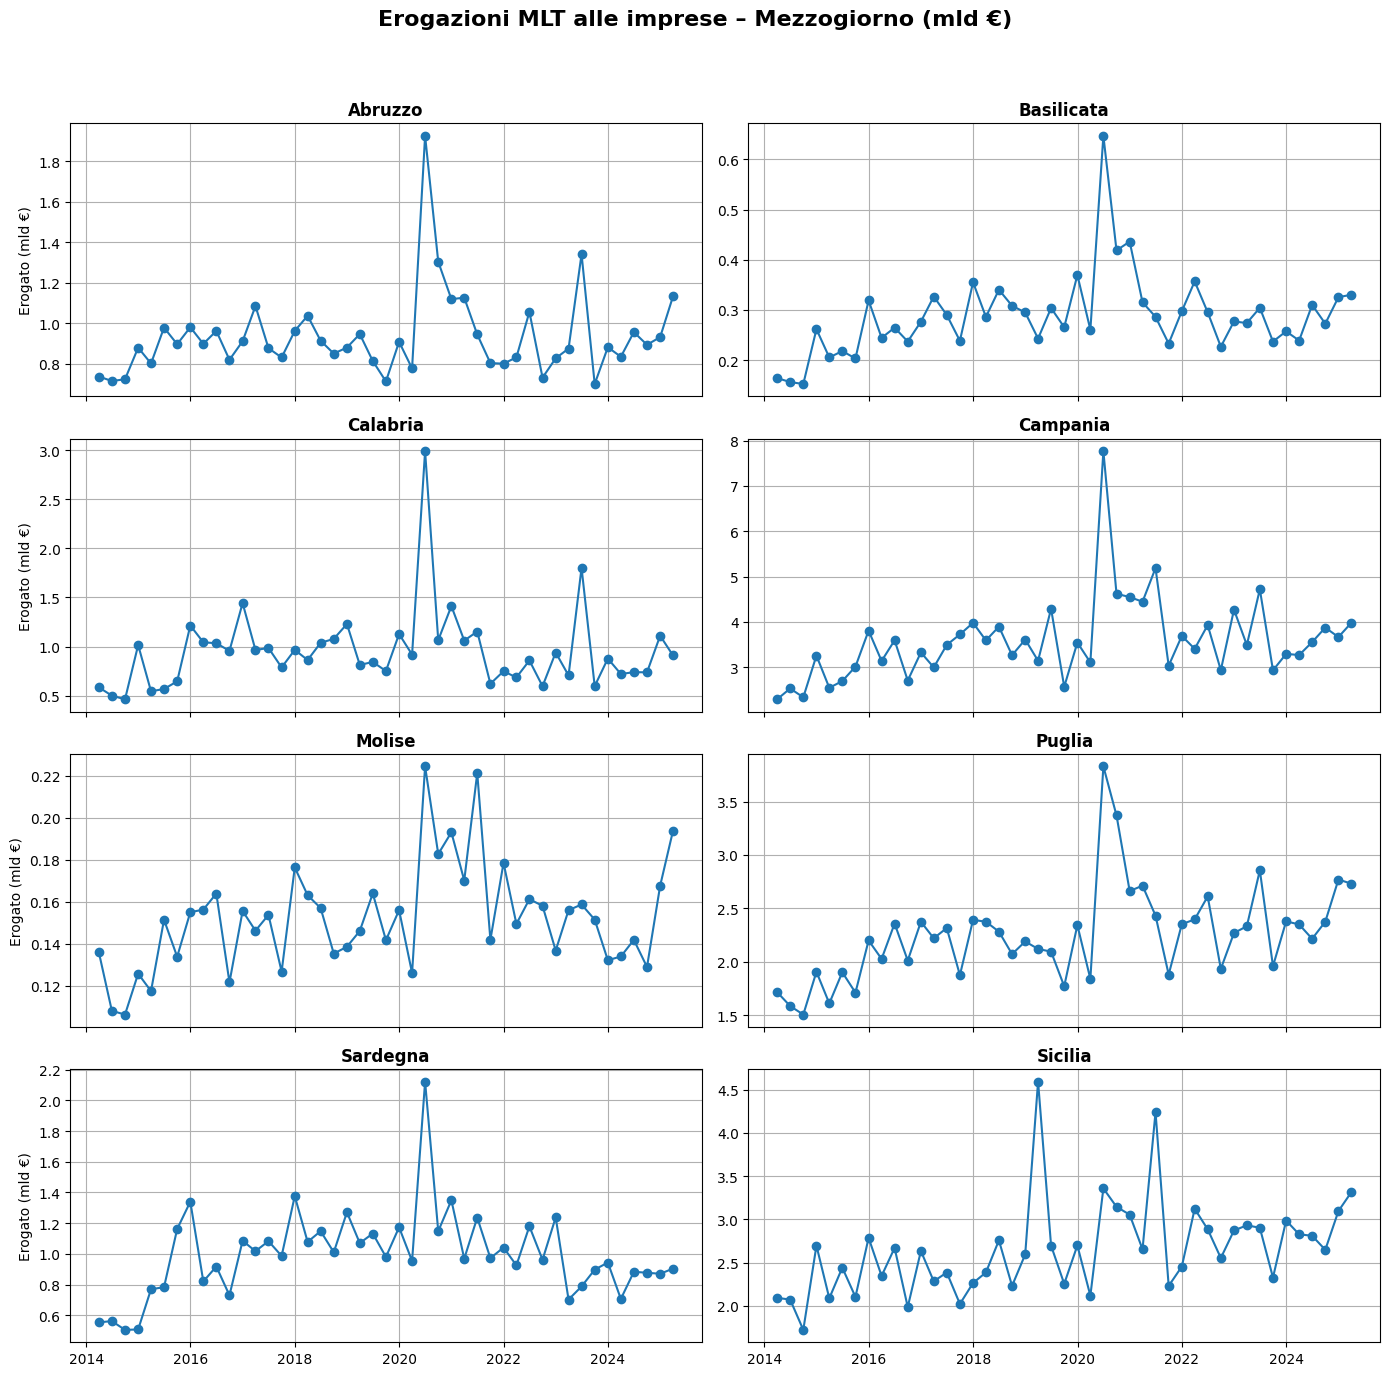

In [82]:
grafico_erogazioni(
    df=data,
    desinv_list=['20', '40', '50', '90', '902', '905', '909', '912', '916'],
    regioni_list=['ITF1','ITF2','ITF3','ITF4','ITF5','ITF6','ITG1','ITG2'],
    facet=True,
    base100=False,
    titolo='Erogazioni MLT alle imprese – Mezzogiorno (mld €)'
)



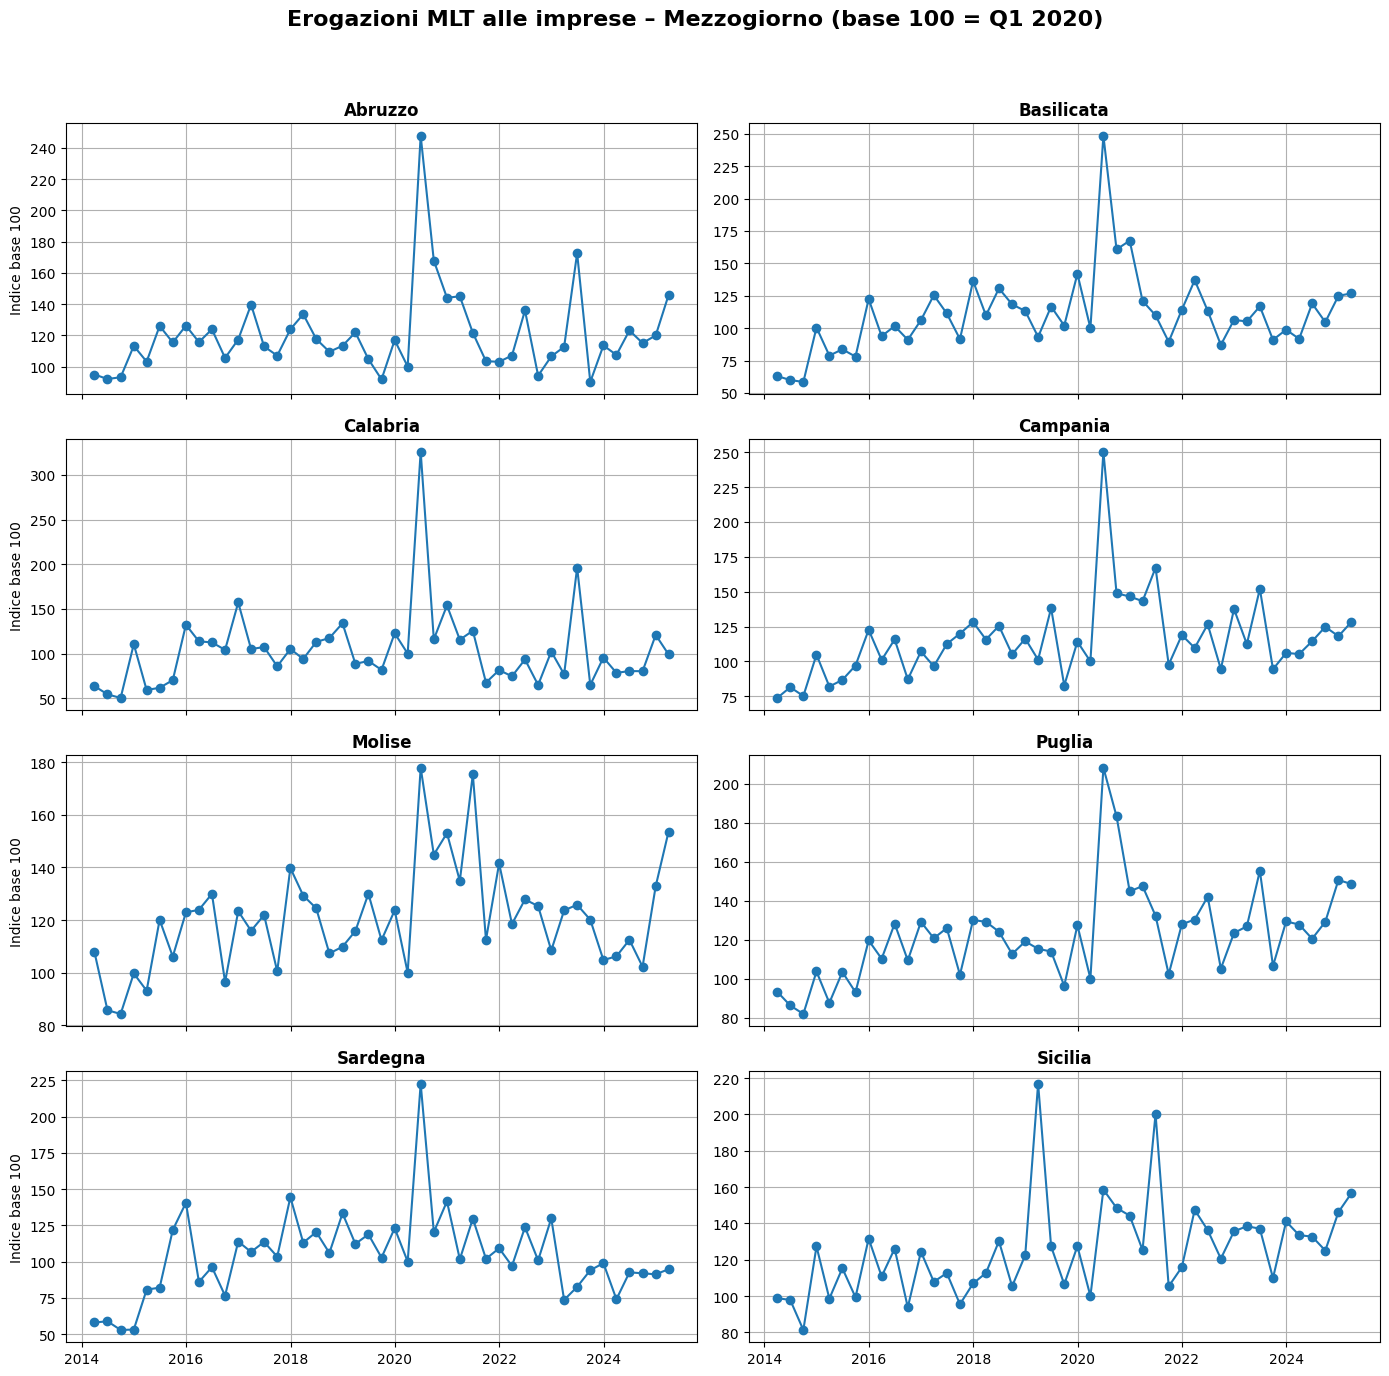

In [83]:
grafico_erogazioni(
    df=data,
    desinv_list=['20', '40', '50', '90', '902', '905', '909', '912', '916'],
    regioni_list=['ITF1','ITF2','ITF3','ITF4','ITF5','ITF6','ITG1','ITG2'],
    facet=True,
    base100=True,
    titolo='Erogazioni MLT alle imprese – Mezzogiorno (base 100 = Q1 2020)'
)



In [ ]:
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Caricamento dataset Bankitalia TFR10430
tabella = 'TFR10430'
file_url = f'https://a2a.bancaditalia.it/infostat/dataservices/export/IT/CSV/DATA/CUBE/BANKITALIA/DIFF/{tabella}'
response = requests.get(file_url)

# Parsing CSV
date_column = ['DATA_OSS']
data = pd.read_csv(
    BytesIO(response.content),
    compression='zip',
    header=0,
    sep=';',
    quotechar='"',
    encoding='utf-8',
    dtype={'ENTE_SEGN': 'str', 'FENEC': 'str', 'VALORE': 'Int32', 'LOC_SPORT': 'Int32'},
    parse_dates=date_column
)
data['DATA_OSS'] = pd.to_datetime(data['DATA_OSS'])

# Caricamento tabella domini
domain_df = pd.read_csv("20250630_074332-DOMAIN-STAFINRA-MULTICUBE.csv", sep=';')

# Conversioni coerenti per join
data['DESINV'] = data['DESINV'].astype(str)
data['LOC_CTP'] = data['LOC_CTP'].astype(str)
data['TIPTASSO'] = data['TIPTASSO'].astype(str)
data['ENTE_SEGN'] = data['ENTE_SEGN'].astype(str)

# Join descrizioni
data = data.merge(
    domain_df[domain_df['Dominio'] == 'DESINV'][['Elemento', 'Descrizione']],
    left_on='DESINV', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'DESINV_DESC'}).drop(columns='Elemento')

data = data.merge(
    domain_df[domain_df['Dominio'] == 'TERRITORIO'][['Elemento', 'Descrizione']],
    left_on='LOC_CTP', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'LOC_CTP_DESC'}).drop(columns='Elemento')

data = data.merge(
    domain_df[domain_df['Dominio'] == 'TIPTASSO'][['Elemento', 'Descrizione']],
    left_on='TIPTASSO', right_on='Elemento', how='left'
).rename(columns={'Descrizione': 'TIPTASSO_DESC'}).drop(columns='Elemento')

# Estrai ultimo periodo disponibile
ultimo_periodo = data['DATA_OSS'].max()

# Output preview del dataset trattato
data.head(10)


DATA_OSS DESINV  DURORI ENTE_SEGN    FENEC LOC_CTP RESIDENZA1 TIPTASSO  \
0  2025-03-31    909      18   1070001  1001531   ITC12         IT      800   
1  2025-03-31    909      18   1070001  1001531   ITC42         IT      800   
2  2025-03-31    916      18   1070001  1001531    ITI3         IT      800   
3  2025-03-31    998      18   1070001  1001531   ITC16         IT      800   
4  2025-03-31    998      18   1070001  1001531   ITH10         IT    10000   
5  2025-03-31    997      18   1070001  1001531   ITG14         IT    10000   
6  2025-03-31    997      18   1070001  1001531   ITG2G         IT       80   
7  2025-03-31    997      18   1070001  1001531   ITC49         IT    10000   
8  2025-03-31    997      18   1070001  1001531    ITC1         IT      800   
9  2025-03-31     10      18   1070001  1001531   ITG2H         IT    10000   
10 2025-03-31    120      18   1070001  1001531   ITF21         IT      800   
11 2025-03-31    120      18   1070001  1001531   ITC15         IT    10000   
12 2025-03-31    902      18   1070001  1001531   ITF62         IT    10000   
13 2025-03-31    902      18   1070001  1001531   ITC13         IT      800   
14 2025-03-31    902      18   1070001  1001531   ITC13         IT    10000   
15 2025-03-31    909      18   1070001  1001531   ITI32         IT      800   
16 2025-03-31    909      18   1070001  1001531   ITI14         IT       80   
17 2025-03-31    909      18   1070001  1001531   ITI31         IT      800   
18 2025-03-31    110      18   1070001  1001531   ITC46         IT    10000   
19 2025-03-31    110      18   1070001  1001531   ITH43         IT      800   

     VALORE  STATUS                                        DESINV_DESC  \
0       856     NaN  Investimenti: acquisto di immobili - altri imm...   
1     35700     NaN  Investimenti: acquisto di immobili - altri imm...   
2   1597514     NaN  Investimenti: destinazioni diverse da acquisto...   
3   1734979     NaN  Invest.diversi dai non finanziari: destin. div...   
4    999222     NaN  Invest.diversi dai non finanziari: destin. div...   
5    225437     NaN                                  Tutte le finalità   
6      1551     NaN                                  Tutte le finalità   
7    956035     NaN                                  Tutte le finalità   
8   7414865     NaN                                  Tutte le finalità   
9      3705     NaN  Investimenti non finanziari: costruzioni - abi...   
10    18466     NaN                            Investimenti finanziari   
11    53334     NaN                            Investimenti finanziari   
12     1801     NaN  Investimenti non finanziari: costruzioni - fab...   
13     2714     NaN  Investimenti non finanziari: costruzioni - fab...   
14     2714     NaN  Investimenti non finanziari: costruzioni - fab...   
15     8497     NaN  Investimenti: acquisto di immobili - altri imm...   
16      364     NaN  Investimenti: acquisto di immobili - altri imm...   
17    12134     NaN  Investimenti: acquisto di immobili - altri imm...   
18    88053     NaN  Altri investimenti: acquisto di beni durevoli ...   
19    11235     NaN  Altri investimenti: acquisto di beni durevoli ...   

     LOC_CTP_DESC                 TIPTASSO_DESC  
0        Vercelli           Tasso non agevolato  
1            Como           Tasso non agevolato  
2          Marche           Tasso non agevolato  
3           Cuneo           Tasso non agevolato  
4   Bolzano-Bozen  Totale tasso agevolato e non  
5       Agrigento  Totale tasso agevolato e non  
6             NaN               Tasso agevolato  
7            Lodi  Totale tasso agevolato e non  
8        Piemonte           Tasso non agevolato  
9    Sud Sardegna  Totale tasso agevolato e non  
10        Isernia           Tasso non agevolato  
11         Novara  Totale tasso agevolato e non  
12        Crotone  Totale tasso agevolato e non  
13         Biella           Tasso non agevolato  
14         Biella  Totale tasso agevolat

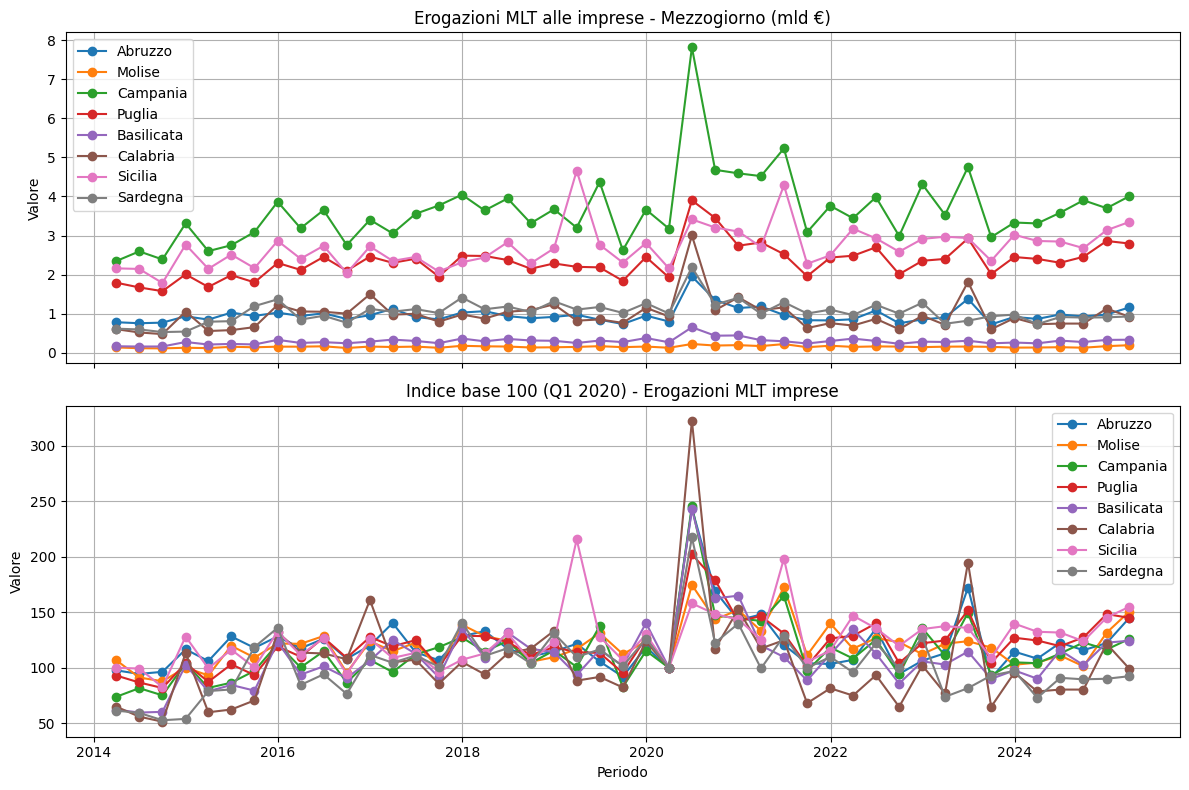

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Regione Mezzogiorno - codici LOC_CTP
regioni_mezzogiorno = {
    'ITF1': 'Abruzzo',
    'ITF2': 'Molise',
    'ITF3': 'Campania',
    'ITF4': 'Puglia',
    'ITF5': 'Basilicata',
    'ITF6': 'Calabria',
    'ITG1': 'Sicilia',
    'ITG2': 'Sardegna',
}

# DESINV coerenti con erogazioni alle imprese
desinv_imprese = [
    '10', '20', '40', '50', '90', '902', '905', '909', '912', '916'
]

# Funzione per il plot
def plot_erogazioni_mlt_imprese_mezzogiorno(data):
    # Filtra solo MLT (TIPTASSO 10000), Mezzogiorno, DESINV imprese, fonte 1070001
    df = data[
        (data['TIPTASSO'] == '10000') &
        (data['ENTE_SEGN'] == '1070001') &
        (data['DESINV'].isin(desinv_imprese)) &
        (data['LOC_CTP'].isin(regioni_mezzogiorno.keys()))
    ].copy()

    # Prepara variabili
    df['VALORE'] = df['VALORE'].astype('int64') * 1000
    df['VALORE_MLD'] = df['VALORE'] / 1e9
    df['DATA_OSS'] = pd.to_datetime(df['DATA_OSS'])
    df['REGIONE'] = df['LOC_CTP'].map(regioni_mezzogiorno)

    # Aggrega
    df_grouped = df.groupby(['DATA_OSS', 'REGIONE'])['VALORE_MLD'].sum().reset_index()

    # Calcolo base 100 rispetto al primo trimestre 2020
    base_2020 = df_grouped[df_grouped['DATA_OSS'] >= '2020-01-01'].sort_values('DATA_OSS').groupby('REGIONE').first()
    df_grouped['INDICE_2020'] = df_grouped.apply(
        lambda row: (row['VALORE_MLD'] / base_2020.loc[row['REGIONE']]['VALORE_MLD']) * 100
        if row['REGIONE'] in base_2020.index else None,
        axis=1
    )

    # Plot affiancato: valori assoluti e indice base 100
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    for regione in regioni_mezzogiorno.values():
        subset = df_grouped[df_grouped['REGIONE'] == regione]
        axes[0].plot(subset['DATA_OSS'], subset['VALORE_MLD'], label=regione, marker='o')
        axes[1].plot(subset['DATA_OSS'], subset['INDICE_2020'], label=regione, marker='o')

    axes[0].set_title('Erogazioni MLT alle imprese - Mezzogiorno (mld €)')
    axes[1].set_title('Indice base 100 (Q1 2020) - Erogazioni MLT imprese')

    for ax in axes:
        ax.grid(True)
        ax.legend()
        ax.set_ylabel('Valore')

    axes[1].set_xlabel('Periodo')
    plt.tight_layout()
    return df_grouped

df_risultato = plot_erogazioni_mlt_imprese_mezzogiorno(data)


In [116]:
import matplotlib.pyplot as plt

def plot_erogazioni_mlt(df, regioni=None):
    """
    Facet plot dell'erogato MLT per regione con due pannelli:
    - Erogato in mld €
    - Indice base 100 rispetto al valore nazionale Q1 2020
    """

    # Somma trimestrale per regione
    df_agg = (
        df.groupby(['DATA_OSS', 'LOC_CTP_DESC'])
        .agg({'VALORE': 'sum'})
        .reset_index()
        .rename(columns={'LOC_CTP_DESC': 'REGIONE'})
    )

    # Conversione in mld €
    df_agg['VALORE_MLD'] = df_agg['VALORE'] / 1_000_000

    # Calcolo valore Italia Q1 2020
    valore_it_q1_2020 = df_agg[
        (df_agg['REGIONE'] == 'Italia') & 
        (df_agg['DATA_OSS'] == pd.to_datetime('2020-03-31'))
    ]['VALORE_MLD'].sum()

    # Calcolo indice base 100 su valore IT
    df_agg['BASE100_IT'] = df_agg['VALORE_MLD'] / valore_it_q1_2020 * 100

    # Selezione regioni se richiesto
    if regioni:
        df_agg = df_agg[df_agg['REGIONE'].isin(regioni)]

    regioni_uniche = sorted(df_agg['REGIONE'].unique())
    n = len(regioni_uniche)

    # Impostazione layout: 2 colonne (Erogato, Indice)
    fig, axs = plt.subplots(n, 2, figsize=(14, 2.8 * n), sharex=True)
    fig.suptitle('Erogazioni MLT alle imprese – Regioni selezionate', fontsize=16, fontweight='bold')

    for i, regione in enumerate(regioni_uniche):
        subset = df_agg[df_agg['REGIONE'] == regione].sort_values('DATA_OSS')

        # Colonna 1: Erogato
        axs[i, 0].plot(subset['DATA_OSS'], subset['VALORE_MLD'], marker='o', color='steelblue')
        axs[i, 0].set_ylabel('mld €')
        axs[i, 0].set_title(f'{regione} – Erogato (mld €)')

        # Colonna 2: Indice base 100 IT
        axs[i, 1].plot(subset['DATA_OSS'], subset['BASE100_IT'], marker='o', color='darkorange')
        axs[i, 1].set_ylabel('Indice base 100')
        axs[i, 1].set_title(f'{regione} – Indice base 100 (Italia Q1 2020)')

        for ax in axs[i]: ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()



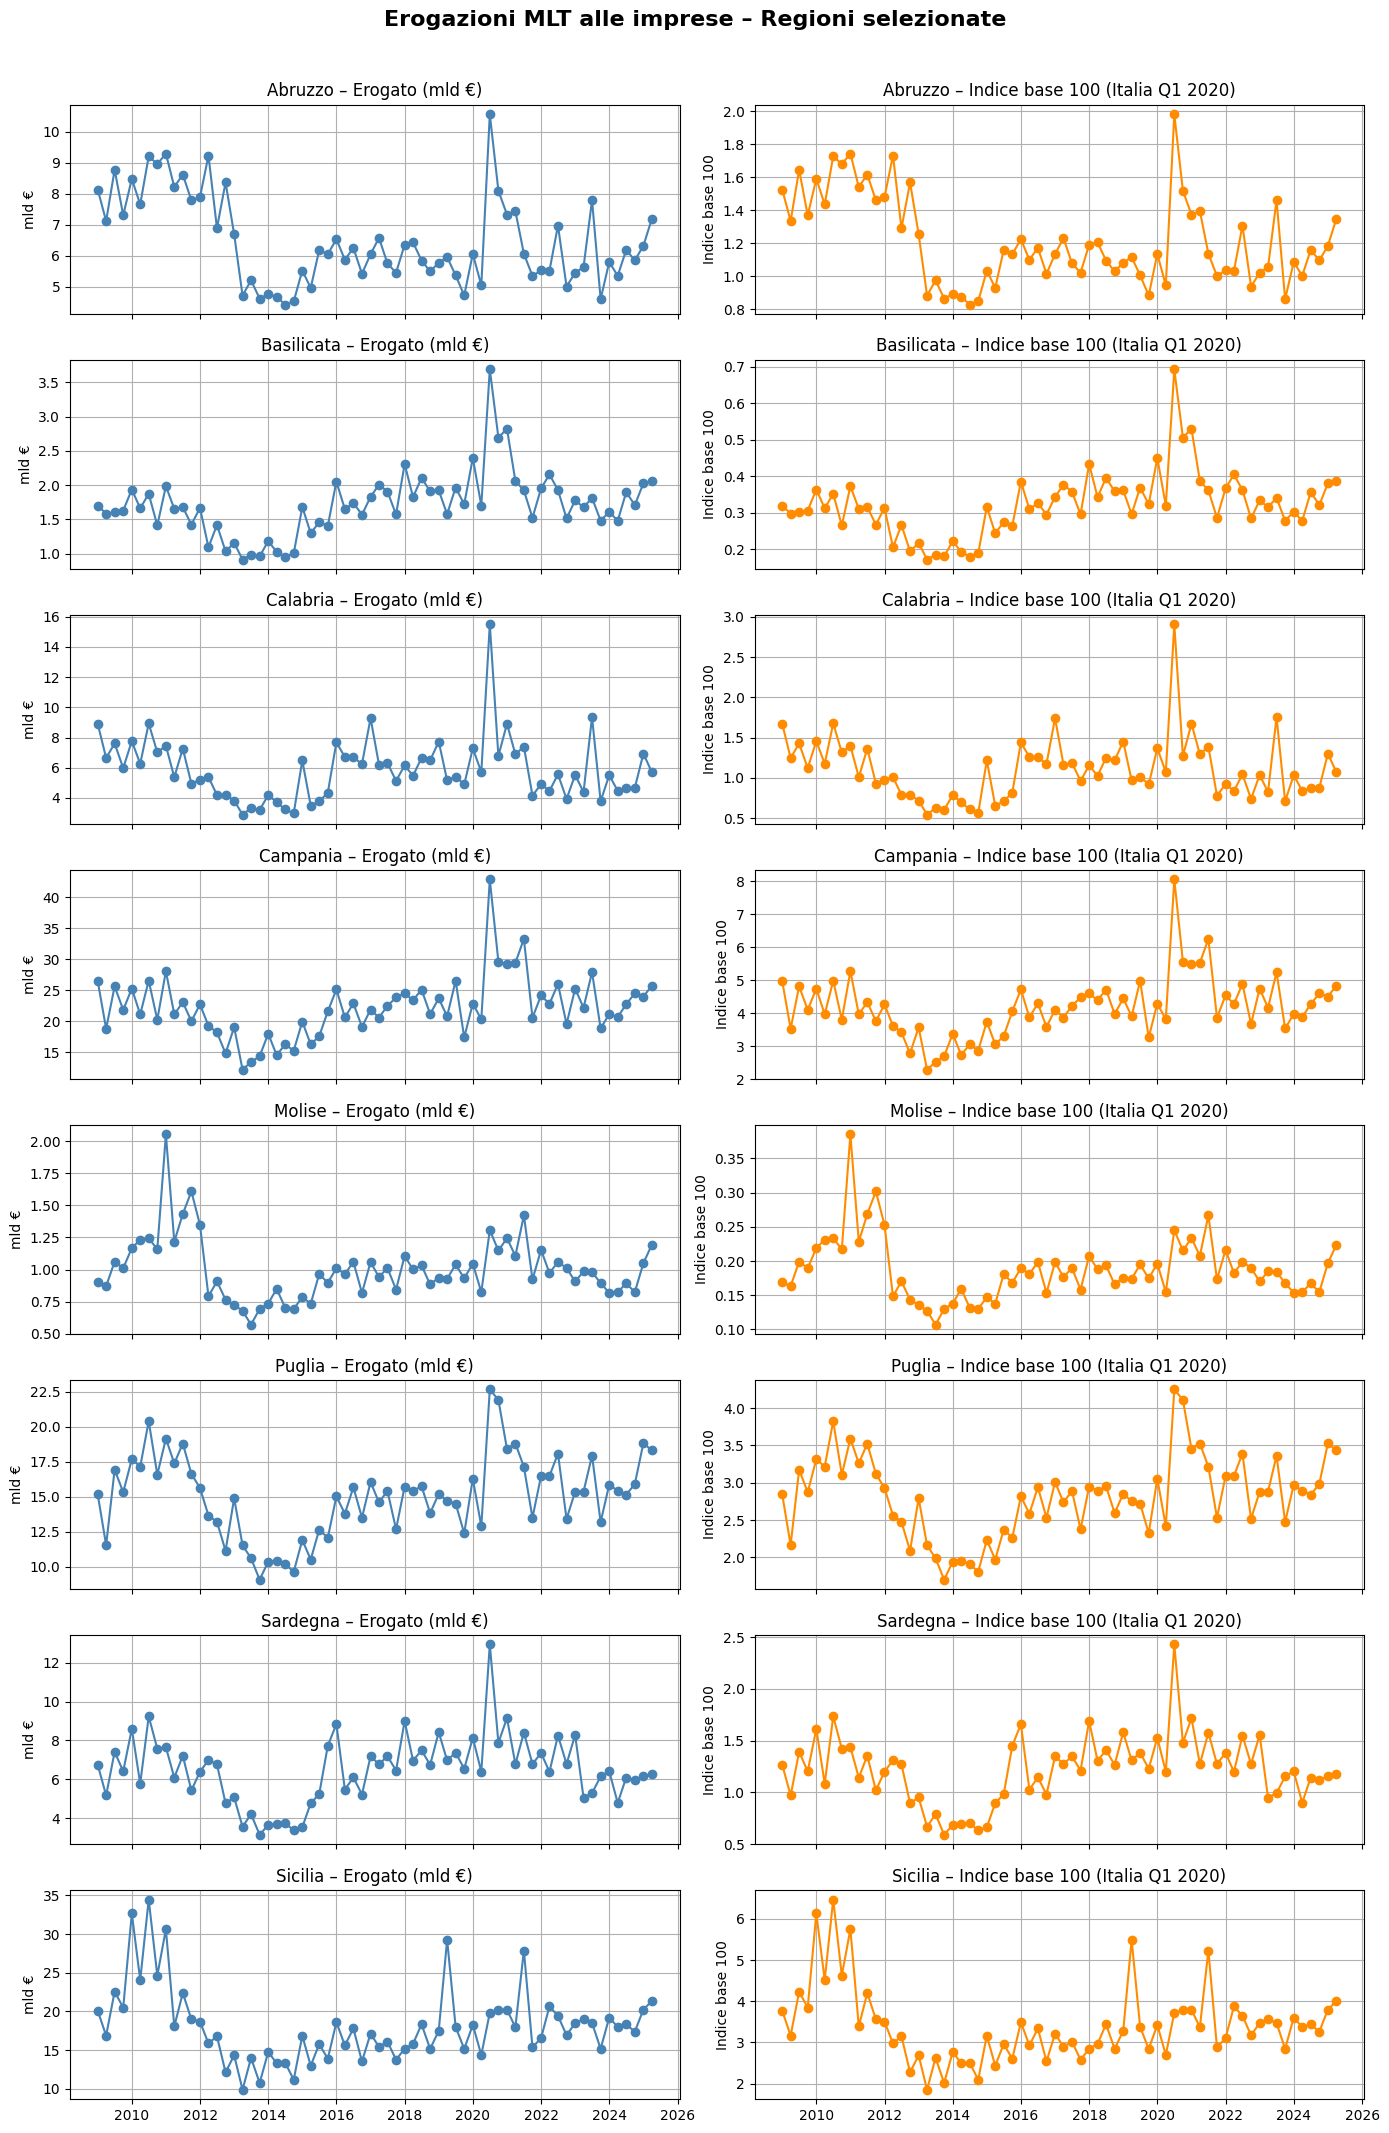

In [117]:
regioni_mezzogiorno = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Molise', 'Puglia', 'Sardegna', 'Sicilia']
plot_erogazioni_mlt(data, regioni=regioni_mezzogiorno)



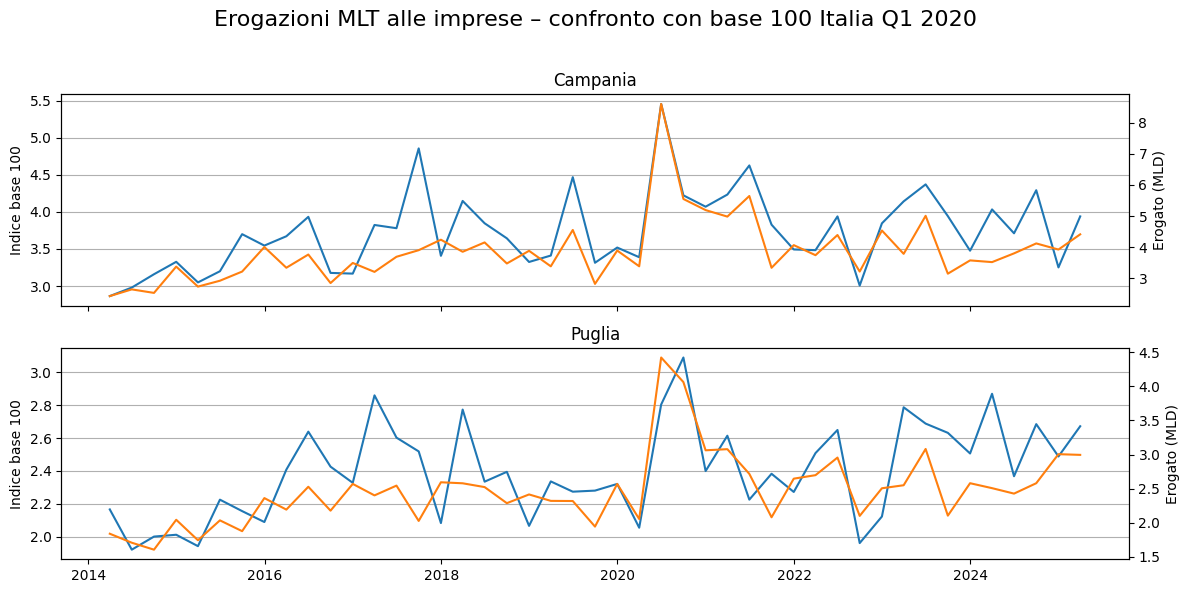

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO

def plot_erogazioni_mlt_base100(
    tabella='TFR10430',
    domain_path='20250630_074332-DOMAIN-STAFINRA-MULTICUBE.csv',
    regioni=None,
    facet=True
):
    # 1. Scarica e leggi dati Bankitalia
    url = f'https://a2a.bancaditalia.it/infostat/dataservices/export/IT/CSV/DATA/CUBE/BANKITALIA/DIFF/{tabella}'
    response = requests.get(url)
    df = pd.read_csv(BytesIO(response.content), compression='zip', sep=';', encoding='utf-8', 
                     parse_dates=['DATA_OSS'], dtype={'ENTE_SEGN':'str','FENEC':'str','VALORE':'Int32',
                                                      'LOC_SPORT':'Int32','LOC_CTP':'str','TIPTASSO':'str',
                                                      'DESINV':'str'})

    # 2. Decodifica domini
    domain = pd.read_csv(domain_path, sep=';')
    df = df.merge(domain[domain['Dominio'] == 'DESINV'][['Elemento', 'Descrizione']], 
                  left_on='DESINV', right_on='Elemento', how='left').rename(columns={'Descrizione': 'DESINV_DESC'}).drop(columns='Elemento')
    df = df.merge(domain[domain['Dominio'] == 'TERRITORIO'][['Elemento', 'Descrizione']], 
                  left_on='LOC_CTP', right_on='Elemento', how='left').rename(columns={'Descrizione': 'REGIONE'}).drop(columns='Elemento')
    df = df.merge(domain[domain['Dominio'] == 'TIPTASSO'][['Elemento', 'Descrizione']], 
                  left_on='TIPTASSO', right_on='Elemento', how='left').rename(columns={'Descrizione': 'TIPTASSO_DESC'}).drop(columns='Elemento')

    # 3. Filtra per MLT, Italia, Tasso aggregato, ENTE_SEGN 1070001
    df = df[
        (df['TIPTASSO'] == '10000') &
        (df['ENTE_SEGN'] == '1070001') &
        (df['LOC_CTP'].str.startswith('IT')) &
        (~df['DESINV'].isin(['110', '212', '70', '80', '914', '996', '997', '998']))
    ]

    # 4. Aggrega per DATA_OSS e REGIONE
    df_grouped = df.groupby(['DATA_OSS', 'REGIONE'])['VALORE'].sum().reset_index()
    df_grouped['VALORE_MLD'] = df_grouped['VALORE'] / 1_000_000

    # 5. Calcolo indice base 100 rispetto a IT, primo trimestre 2020
    df_italia = df_grouped[df_grouped['REGIONE'] == 'Italia'].copy()
    base_italia_2020 = df_italia[df_italia['DATA_OSS'] == pd.to_datetime('2020-03-31')]['VALORE_MLD'].values[0]
    df_italia['BASE100'] = (df_italia['VALORE_MLD'] / base_italia_2020) * 100

    base_map = df_italia.set_index('DATA_OSS')['BASE100'].to_dict()

    # 6. Crea base 100 regionale su base Italia
    df_grouped['BASE100'] = df_grouped.apply(
        lambda row: (row['VALORE_MLD'] / base_map[row['DATA_OSS']]) * 100 if row['DATA_OSS'] in base_map else None,
        axis=1
    )

    # 7. Filtro facoltativo regioni
    if regioni:
        df_grouped = df_grouped[df_grouped['REGIONE'].isin(regioni)]

    # 8. Grafico facet
    regioni_uniche = df_grouped['REGIONE'].unique()
    n = len(regioni_uniche)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)

    if n == 1:
        axs = [axs]

    for ax, regione in zip(axs, regioni_uniche):
        sub = df_grouped[df_grouped['REGIONE'] == regione]
        ax2 = ax.twinx()
        ax.plot(sub['DATA_OSS'], sub['BASE100'], label='Indice base 100 Italia', color='tab:blue')
        ax2.plot(sub['DATA_OSS'], sub['VALORE_MLD'], label='Erogato MLD', color='tab:orange')
        ax.set_ylabel('Indice base 100')
        ax2.set_ylabel('Erogato (MLD)')
        ax.set_title(regione)
        ax.grid(True, axis='y')

    fig.suptitle('Erogazioni MLT alle imprese – confronto con base 100 Italia Q1 2020', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Esegui per Campania e Puglia come test
plot_erogazioni_mlt_base100(regioni=['Campania', 'Puglia'])



In [120]:
import matplotlib.pyplot as plt

# Regioni Mezzogiorno
mezzogiorno = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Molise', 'Puglia', 'Sardegna', 'Sicilia']

# Filtra il dataset per le regioni del Mezzogiorno
df_mezzogiorno = df_grouped[df_grouped['REGIONE'].isin(mezzogiorno)].copy()

# Ordina
df_mezzogiorno.sort_values(['REGIONE', 'DATA_OSS'], inplace=True)

# Calcola l'indice base 100 rispetto all'Italia al primo trimestre 2020
base_it_2020 = df_grouped[
    (df_grouped['REGIONE'] == 'Italia') &
    (df_grouped['DATA_OSS'] == pd.to_datetime('2020-03-31'))
]['VALORE_MLD'].values[0]

df_mezzogiorno['BASE100'] = (df_mezzogiorno['VALORE_MLD'] / base_it_2020) * 100

# Plot: 8 righe, 2 colonne (valore assoluto / base 100)
fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(14, 30), sharex=True)
fig.suptitle('Erogazioni MLT alle imprese – Mezzogiorno (Valori e Base 100 su Italia Q1-2020)', fontsize=16, fontweight='bold')

for i, regione in enumerate(mezzogiorno):
    regione_data = df_mezzogiorno[df_mezzogiorno['REGIONE'] == regione]

    # Colonna 1: valori assoluti
    axs[i, 0].plot(regione_data['DATA_OSS'], regione_data['VALORE_MLD'], marker='o')
    axs[i, 0].set_ylabel('Mld €')
    axs[i, 0].set_title(regione)
    axs[i, 0].grid(True, axis='y')

    # Colonna 2: base 100
    axs[i, 1].plot(regione_data['DATA_OSS'], regione_data['BASE100'], marker='o', color='orange')
    axs[i, 1].set_ylim(50, 200)
    axs[i, 1].set_ylabel('Indice (base 100 = IT Q1-2020)')
    axs[i, 1].grid(True, axis='y')

for ax in axs[-1]:
    ax.set_xlabel('Data')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


KeyError: 'REGIONE'

In [118]:
df_agg[df_agg['REGIONE'] == 'Campania'].sort_values('DATA_OSS')[['DATA_OSS', 'VALORE_MLD', 'BASE100']]



DATA_OSS  VALORE_MLD     BASE100
3   2014-03-31    2.289740   73.797591
11  2014-06-30    2.528304   81.486433
19  2014-09-30    2.333728   75.215310
27  2014-12-31    3.254037  104.876576
35  2015-03-31    2.543782   81.985284
43  2015-06-30    2.691688   86.752247
51  2015-09-30    3.010771   97.036191
59  2015-12-31    3.805613  122.653695
67  2016-03-31    3.135823  101.066577
75  2016-06-30    3.591833  115.763634
83  2016-09-30    2.703563   87.134975
91  2016-12-31    3.324435  107.145482
99  2017-03-31    2.993880   96.491799
107 2017-06-30    3.490296  112.491129
115 2017-09-30    3.722034  119.959971
123 2017-12-31    3.977789  128.202873
131 2018-03-31    3.589631  115.692664
139 2018-06-30    3.894059  125.504282
147 2018-09-30    3.261944  105.131417
155 2018-12-31    3.609410  116.330135
163 2019-03-31    3.139758  101.193401
171 2019-06-30    4.288081  138.203485
179 2019-09-30    2.565800   82.694917
187 2019-12-31    3.543031  114.190761
195 2020-03-31    3.102730  100.000000
203 2020-06-30    7.770395  250.437357
211 2020-09-30    4.618480  148.852140
219 2020-12-31    4.547419  146.561866
227 2021-03-31    4.443435  143.210495
235 2021-06-30    5.185810  167.137005
243 2021-09-30    3.030699   97.678464
251 2021-12-31    3.688808  118.889107
259 2022-03-31    3.403352  109.688951
267 2022-06-30    3.927441  126.580173
275 2022-09-30    2.932388   94.509932
283 2022-12-31    4.269009  137.588801
291 2023-03-31    3.487108  112.388381
299 2023-06-30    4.717493  152.043297
307 2023-09-30    2.929178   94.406474
315 2023-12-31    3.292691  106.122383
323 2024-03-31    3.266363  105.273839
331 2024-06-30    3.552174  114.485437
339 2024-09-30    3.872249  124.801352
347 2024-12-31    3.663657  118.078499
355 2025-03-31    3.978064  128.211736